In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

[View in Colaboratory](https://colab.research.google.com/github/workmanjack/W207_Group_Project/blob/master/w207_openbarbell_part2_lifter_clustering.ipynb)

# W207 Final Project: OpenBarbell

# Part 2. Lifter Clustering

## 11 August 2018

### Project Overview

Please see our notebook for Part 1: Exercise Classification for an overview of this project and data:
https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_part1_exercise_classification.ipynb

### Why Lifter Clustering?

The OpenBarbell project provides powerlifters with key lifting metrics during a lifter's workout. With these metrics, it is easy for lifters to compare themselves to other lifters. However, not all lifters are the same and these comparisons are not always useful. For example, a beginner lifter will not learn much from comparing their data to that of an advanced lifter and vice versa. Ideally, a beginner lifter would be able to compare themselves to lifters of a similar caliber or, in other words, to lifters within their *cluster*. This is precisely the goal of our work here for Part 2 of our W207 Final Project.

### Solving the Problem

To group lifters into clusters, we first clean and group the data by user. We then make use of Hierarchical Clustering to form our clusters. Finding the right set of parameters to output distinct clusters required several iterations of this process. By looking through this notebook, you can follow along as we clean, analyze, cluster, analyze some more, and finally demonstrate what it might look like for a user comparing their data to another lifter's data.

### Table of Contents

1. Import the Data
2. EDA for Lifter Segmentation
3. Data Preprocessing
4. Data Cleaning
5. Separate Data Into Train & Test Sets
6. Feature Visualization
7. Hierarchical Clustering
8. Bringing It All Together
9. Validation
10. Example User

In [2]:
#!git clone https://github.com/YuliaZamriy/W207_Group_Project.git

# run if using google colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install -q keras

## make sure Google Drive is mounted
!ls 

In [3]:
import warnings
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import sys
import itertools
from mpl_toolkits.mplot3d import Axes3D
from locale import atof
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode

%matplotlib inline
VERBOSE = True

warnings.filterwarnings(action='once')

/home/yulia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# suppress scientific float notation
np.set_printoptions(precision=5, suppress=True)

# 1. Import The Data

More information on the data as well as additional EDA can be viewed in our notebook for Part 1:
https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_part1_exercise_classification.ipynb

# upload raw dataset
df = pd.read_csv("drive/Colab Notebooks/ob_data_w207_filtered.csv")

In [5]:
# Uncomment this if running locally on Jupyter Notebooks

csv_data_file = 'ob_data_w207_filtered.csv'
zip_data_file = 'ob_data_w207_filtered.zip'

locale.setlocale(locale.LC_NUMERIC, '')

df = None
if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
    zip_ref = zipfile.ZipFile(zip_data_file, 'r')
    zip_ref.extractall()
    zip_ref.close()
if os.path.exists(csv_data_file):
    df = pd.read_csv(csv_data_file)
    # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
    #df = pd.read_csv(csv_data_file, decimal='.')
else:
    raise Exception('Data file not found! {0}'.format(csv_data_file))

In [6]:
df.shape

(292910, 45)

# 2. EDA for Lifter Clustering

The Lifter Clustering problem differs from the Exercise Classification problem because we are viewing the data at a user level rather than a per-rep perspective. Because of this, not all the provided data points are useful. Here, we attempt to narrow down the list of parameters to consider based on exploratory data analysis as well as prior domain knowledge as well as explore how best to group the data by user.

### Potential features to consider for lifter segmentation:

 Lifting-related:
 
 - `rpe_num`: uses RPE or not
 - `weight_lbs`
 - `RepCount`: values start from 0 (counts of 1); higher repper vs. low
 - `ROM`
 - `AvgVel`
 - `PeakVel`
 - `PeakVelLoc`
 - `RepDur`
 - `PeakAccel`


User-related (can be considered in future analysis):

 - `initialStartTime` / `startTime` / `time`
 - `tags`: tagger or not
 - `workoutID`: number of unique workouts
 - `hardware`:  two values: (ios, android)
 - `deviceName`/`deviceIdentifier`:  how many devices is using
 
 
 ### Potential lifter identifiers:
 
 - Primary: `userID`
 - Secondary: `exercise_clean`


### 2.1 Unique User IDs

Since the clustering will be performed by user and not by rep, we want to make sure that there is enough user-level data in the provided data. Each user is best represented by `userID` (a unique ID for each OpenBarbell application instance). It is technically possible for multiple users to use the same app but determining that is not possible with the provided data.

In [7]:
def feature_descr(feature, ends=5):
    """
    Prints out descriptive information for an input feature:
    - descriptive statistics
    - number of lowest occuring values
    - number of highest occuring values
    - historgram

    Args:
    feature: series or array

    Kwargs:
    ends: int, number of lowest/highest values to analyze
    """

    print(f"{feature.name} Summary:")
    print(feature.describe())

    low = userID_count.sort_values(ascending=True).unique()[:ends]
    high = userID_count.sort_values(ascending=False).unique()[:ends]

    print(f"\nLow occurrence for {feature.name}:")
    for i in low:
        print(
            f"There are {sum(feature==i)} unique values with {i} observation(s)"
        )

    print(f"\nHigh occurrence for {feature.name}:")
    for i in high:
        print(
            f"There are {sum(feature==i)} unique values with {i} observation(s)"
        )

    xmin, xmax = np.min(feature), np.nanpercentile(feature, 99)
    plt.hist(feature, 100, facecolor='g', alpha=0.75)
    plt.xlim([xmin, xmax])
    plt.title(f"Histogram for {feature.name}", fontsize=20)
    plt.show()

userID_count Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID_count, dtype: float64

Low occurrence for userID_count:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)

High occurrence for userID_count:
There are 1 unique values with 10568 observation(s)
There are 1 unique values with 7315 observation(s)
There are 1 unique values with 5944 observation(s)
There are 1 unique values with 5824 observation(s)
There are 1 unique values with 5812 observation(s)


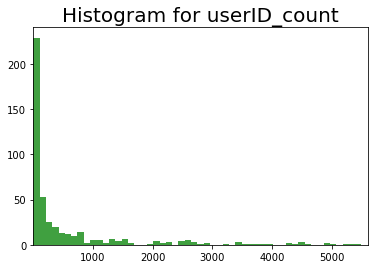

In [8]:
# how many unique user ids in the dataset?
userID_count = df['userID'].value_counts()
userID_count.name = 'userID_count'
feature_descr(userID_count)

In [9]:
def check_frequency(feature, top=10):
    """
    Displays frequency of unique values.
    If there are more than ten unique values, displays only top 10

    Args:
      feature: array

    Kwargs:
      top: int, number of unique values to display
    """

    counts = feature.value_counts()
    print(f"\n{feature.name} has {counts.shape[0]} unique values")
    print("Top 10 values are:")
    if counts.shape[0] > 10:
        print(counts[:10])
    else:
        print(counts)

In [10]:
# get number of reps for each exercise
check_frequency(df['exercise_clean'])


exercise_clean has 6 unique values
Top 10 values are:
bench             94640
squat             77680
squat other       42141
deadlift          35966
bench other       35117
deadlift other     7366
Name: exercise_clean, dtype: int64


In [11]:
# Getting the counts for user+exercise grouping
# Selecting only 3 clean exercises since they are the main lifts of interest
df_temp = df.loc[df['exercise_clean'].isin(["squat", "bench", "deadlift"])]
df_grouped_exercise = df_temp.groupby(['userID', 'exercise_clean'])
df_grouped_exercise = df_grouped_exercise.size()
df_grouped_exercise.name = 'userID-exercise_count'

In [12]:
# Checking how many users have data with multiple exercises
df_grouped_exercise2 = df_grouped_exercise.groupby('userID')
df_grouped_exercise2 = df_grouped_exercise2.size()
check_frequency(df_grouped_exercise2)


userID-exercise_count has 3 unique values
Top 10 values are:
3    183
1    142
2     95
Name: userID-exercise_count, dtype: int64


#### What does this tell us?

From the above output, we can see that grouping by userID gives us a few hundred data points from a variety of users and an okay distribution across exercises. This is enough to let us begin experimenting with clustering.

### 2.2 Feature EDA 

Above, we listed a series of features that might prove useful for lifter clustering based on prior domain knowledge. Here, we explore these features to see if there is anything peculiar we need to pay attention to.

In [13]:
# list of most informative metrics
ls_cont_features = [
    'rpe_num', 'RepCount', 'weight_lbs', 'AvgVel', 'ROM', 'PeakVel',
    'PeakVelLoc', 'RepDur', 'PeakAccel'
]

In [14]:
def get_descr(data, features=None):
    """
    Outputs descriptive data on the input dataset
    including pct missing and zeros

    Args:
      data: dataframe

    Kwargs:
      features: list, features to output

    Returns:
      dataframe with features as columns and 
      descriptives as rows
    """

    if features is None:
        features = data.columns
    data_descr = data[features].describe()

    # calculate percent of missing values
    pct_missing = pd.Series(
        100 - np.around(data_descr.loc['count', ] / data.shape[0] * 100, 2))
    pct_missing.name = 'pct_missing'

    # calculate percent of zeros
    pct_zero = pd.Series(
        [100 * sum(data[v] == 0) / data.shape[0] for v in features])
    pct_zero.name = 'pct_zeros'
    pct_zero.index = pct_missing.index
    data_descr = data_descr.append(pct_missing)
    data_descr = data_descr.append(pct_zero)

    return data_descr


get_descr(df, ls_cont_features)

,rpe_num,RepCount,weight_lbs,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,PeakAccel
count,107928.000000,292910.000000,283142.000000,292891.000000,292910.000000,292910.000000,288513.000000,2.885130e+05,204717.000000
mean,7.330340,2.775013,235.271909,0.479184,462.061456,0.771857,72.132299,1.102977e+06,15.439559
std,1.201296,4.143754,105.251502,0.223486,157.312786,0.377337,20.038203,4.745798e+05,59.320897
min,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.500000,1.000000,165.000000,0.320720,326.000000,0.483974,65.000000,7.656250e+05,3.307050
50%,7.000000,2.000000,225.000000,0.435733,450.000000,0.718287,79.000000,1.030670e+06,6.186958
75%,8.000000,4.000000,300.000000,0.591369,598.000000,0.976293,87.000000,1.363892e+06,12.775880
max,10.000000,114.000000,1000.000000,2.960175,1761.000000,5.560000,99.000000,1.129953e+07,2686.953000
pct_missing,63.150000,0.000000,3.330000,0.010000,0.000000,0.000000,1.500000,1.500000e+00,30.110000
pct_zeros,0.000000,22.791984,0.130415,0.001366,0.001366,0.001366,0.013997,6.145232e-03,0.017411


#### What does this tell us?

1. A wide variety of units - we will need to standardize when clustering
2. Missing values - pct_missing is not zero for all parameters (we solve this with imputing later)

### 2.3 Workouts Per User Analysis


We would like to do some exploratory analysis of the number of workouts per user captured in the database. 
This will give us an idea of how sparse the is data for some of the lifters.

In [15]:
# Getting user level unique workout counts
df_grouped_wourkout = df.groupby(['userID', 'workoutID'])
df_grouped_wourkout = df_grouped_wourkout.size()
df_grouped_wourkout.name = 'userID-workoutID_count'

In [16]:
# checking how many workouts per user are most frequently in the database
check_frequency(df_grouped_wourkout)


userID-workoutID_count has 137 unique values
Top 10 values are:
3     430
15    406
20    359
9     323
2     314
12    307
18    307
4     302
6     302
24    298
Name: userID-workoutID_count, dtype: int64


In [17]:
# checking the user with the max amount reps per user+workout
df_grouped_wourkout.loc[df_grouped_wourkout == max(df_grouped_wourkout)]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
Name: userID-workoutID_count, dtype: int64

In [18]:
# this is account used for S&S internal study
# we might need to exclude it (because it's for multiple people)
df_study = df.loc[df['userID'] == '5aa35456880e87b3f32ddf7c']
df_study.shape

(3506, 45)

In [19]:
# checking the top occuring values for user+workout
# values are number of reps per user+workout
df_grouped_wourkout.sort_values(ascending=False)[:10]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
                          7464e24b-25af-4435-a29e-6735cf838dd4    305
                          870ca10a-1f71-4cbf-a3f8-6ef0f0cc56c1    281
                          21b51e5a-6a80-48d8-827b-b2309f4cd405    201
5a43c264fd4ef00da9b8ccce  3388ac48-1f31-46c1-88db-d82b72209a01    184
5a15b00e05cbc9b8ef26ac59  4d2ad298-337d-46bb-bd46-49f45d42158e    183
59debbdd05cbc9b8ef26ac1c  dbc82f2e-0401-43c6-9c9a-afc52434f724    176
5aa35456880e87b3f32ddf7c  908fe3e3-34c9-4c2f-8ae4-7d22354e2b9b    175
589d473d6ca711fcd8cb7af9  93a67da5-12c4-42d1-a067-ca77e04af8ab    174
5a43c264fd4ef00da9b8ccce  426232d3-7874-4c44-9a5a-6e9b860bbf1c    151
Name: userID-workoutID_count, dtype: int64

#### What does this tell us?

This confirms what we observed before. Some lifters use OpenBarbell far more often than others.

# 3. Data Preprocessing

Each row in the initial dataset corresponds to one rep performed by a user. Lifters usually perform various number of reps in a set and multiple sets in a workout. In this section, we attempt to summarize the characterization of each user's squat, bench, or deadlift by grouping and aggregating certain features.

#### Why do we group by exercise?

The goal is to provide feedback to a given lifter on how they compare with other similar lifters. However, this does not scale across exercises. Two lifters might have matching metrics for their squats but might differ wildly for their bench press. That means they should be in the same cluster for squats but different clusters for bench press. To keep things clean and concise and to ensure that the clustering remains intuitive, we group by exercise.

In [20]:
def data_preprocessing(data):
    """
    Performs any necessary operations to process the data
    before beginning any other operations

    Args:
        data: dataframe

    Returns:
        processed dataframe
    """
    # RepCount is zero-index in the dataset; here we adjust
    # it to be one-indexed as it is more intuitive
    data = data.assign(RepCount=data['RepCount'] + 1)
    return data


def select_exercise(data,
                    exercise,
                    exercise_col='exercise_clean',
                    verbose=False):
    """
    Slices the provided data to contain only the specified exercise

    Args:
        data: dataframe
        exercise: str, exercise to select
        exercise_col: str, column of exercises to do the slicing in

    Kwargs:
        verbose: bool, flag to enable additional output

    Returns:
        dataframe filtered to only contain the specified exercise
    """
    exercise_only = data.loc[data[exercise_col].isin([exercise])]
    # exercise_only = exercise_only.drop('exercise_clean', axis=1)

    if verbose:
        print('Selected Exercise "{0}": shape_before={1}, shape_after={2}'
              .format(exercise, data.shape, exercise_only.shape))

    return exercise_only


def group_data(data, group_cols, feature_cols):
    """
    Groups the data based on the provided set of columns

    Args:
        data: dataframe
        group_cols: columns to use to group
        feature_cols: cols to retain in grouping operation

    Returns:
        Groupby dataframe grouped by provided cols
    """
    data = data[group_cols + feature_cols].groupby(group_cols)
    return data


def aggregate_data(data, aggregator_funcs, verbose=False):
    """
    Aggregates the data in the dataframe with the given functions

    Args:
        data: dataframe
        aggregator_funcs: list, numpy functions to use as aggregators

    Kwargs:
        verbose: bool, flag to enable additional output

    Returns:
        dataframe aggregated with the functions,
        list of columns created by aggregation
    """
    data_aggd = data.agg(aggregator_funcs)
    data_aggd.columns = data_aggd.columns.map('_'.join)
    features = list(data_aggd.columns)

    if verbose:
        print('Aggregated Data: shape={0}'.format(data_aggd.shape))
        print('Features={0}'.format(features))

    return data_aggd, features


def group_and_aggregate_data(data,
                             group_cols,
                             feature_cols,
                             aggregator_funcs,
                             verbose=False):
    """
    Groups and aggregates the data

    See group_data and aggregate_data

    Args:
        data: dataframe
        group_cols: columns to use to group
        feature_cols: cols to retain in grouping operation
        aggregator_funcs: list, numpy functions to use as aggregators

    Kwargs:
        verbose: bool, flag to enable additional output

    Returns:
        dataframe grouped and aggregated,
        list of features in dataset
    """
    grouped = group_data(data, group_cols, feature_cols)
    aggregated, features = aggregate_data(grouped, aggregator_funcs, verbose)

    grp_and_aggd = aggregated.reset_index()

    # we do not need groupby columns anymore
    # grp_and_aggd = grp_and_aggd.drop(group_cols, axis=1)

    if verbose:
        print('Grouped and Aggregated Data: shape={0}'.format(
            grp_and_aggd.shape))

    return grp_and_aggd, features

In [21]:
# divide the dataset into three sub-datasets one for each exercise
df_proc = data_preprocessing(df)

df_bench = select_exercise(df_proc, 'bench', verbose=VERBOSE)
df_squat = select_exercise(df_proc, 'squat', verbose=VERBOSE)
df_deadlift = select_exercise(df_proc, 'deadlift', verbose=VERBOSE)

Selected Exercise "bench": shape_before=(292910, 45), shape_after=(94640, 45)
Selected Exercise "squat": shape_before=(292910, 45), shape_after=(77680, 45)
Selected Exercise "deadlift": shape_before=(292910, 45), shape_after=(35966, 45)


In [22]:
# These will be our primary features of interest
feature_cols = [
    'weight_lbs', 'RepDur', 'AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc'
]
# Grouping variables (clusters will be on user+exercise level)
group_cols = ['userID', 'exercise_clean']
# Aggregation metric
aggregator_funcs = [np.mean]

df_bench_grouped, final_features = group_and_aggregate_data(
    df_bench, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)
df_squat_grouped, _ = group_and_aggregate_data(
    df_squat, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)
df_deadlift_grouped, _ = group_and_aggregate_data(
    df_deadlift, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)

Aggregated Data: shape=(323, 6)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean', 'PeakVel_mean', 'PeakVelLoc_mean']
Grouped and Aggregated Data: shape=(323, 8)
Aggregated Data: shape=(311, 6)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean', 'PeakVel_mean', 'PeakVelLoc_mean']
Grouped and Aggregated Data: shape=(311, 8)
Aggregated Data: shape=(247, 6)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean', 'PeakVel_mean', 'PeakVelLoc_mean']
Grouped and Aggregated Data: shape=(247, 8)


In [23]:
# Checking one of the datasets to make sure everything looks reasonable
get_descr(df_deadlift_grouped, list(df_deadlift_grouped)[2:])

,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean
count,241.000000,2.440000e+02,247.000000,247.000000,247.000000,244.000000
mean,322.180102,1.247090e+06,0.499450,499.029429,0.869304,68.305104
std,110.175352,4.075544e+05,0.281082,92.555539,0.500868,7.668018
min,2.666667,2.252466e+05,0.168204,194.666667,0.254768,31.000000
25%,245.413513,9.766092e+05,0.336801,449.766646,0.591357,65.165385
50%,315.000000,1.211856e+06,0.440215,504.720000,0.773433,69.143287
75%,391.818182,1.486355e+06,0.578724,549.916865,1.012934,72.632184
max,892.871100,2.609518e+06,2.619066,1146.444444,5.135615,93.000000
pct_missing,2.430000,1.210000e+00,0.000000,0.000000,0.000000,1.210000
pct_zeros,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


#### What did we do?

We grouped the dataset by userID and by exercise and computed the mean of each of the parameters of interest. This leaves us with three datasets: bench press, squat and deadlift.

# 4. Data Cleaning

Before clustering, there are two issues that must be resolved. The first is missing data which we handle with sklearn's Imputer. The second is standardizing feature values. This we accomplish with sklearn's StandardScaler class.

## 4.1 Handle Missing Data

In [24]:
def impute_data(data, verbose=False):
    """
    Imputes missing values with medians to avoid skews by outliers

    Args:
        data: feature dataset used to fit and apply impute calculations

    Kwargs:
        verbose: bool, specifies whether to print out the checks

    Returns:
        input dataset with imputed means
    """

    # separate ids
    ids = data[group_cols]
    # keep only features for imputations
    data = data.drop(group_cols, axis=1)

    data_im = preprocessing.Imputer(strategy='median').fit_transform(data)
    data_im = pd.DataFrame(data_im, index=data.index, columns=data.columns)

    if verbose:
        print(f"\nFeature means before impute:\n {round(data.mean(),2)}")
        print(f"\nNumber of missing values: {data.isnull().sum().sum()}")
        print(f"\nFeature means after impute:\n {round(data_im.mean(),2)}")
        print(f"\nNumber of missing after impute:\n {np.isnan(data_im).sum()}")

    # merge ids back with features
    data_im = data_im.join(ids)

    return data_im

In [25]:
print("\nProcessing for bench:")
df_bench_imputed = impute_data(df_bench_grouped, verbose=VERBOSE)
print("\nProcessing for squat:")
df_squat_imputed = impute_data(df_squat_grouped, verbose=VERBOSE)
print("\nProcessing for deadlift:")
df_deadlift_imputed = impute_data(df_deadlift_grouped, verbose=VERBOSE)


Processing for bench:

Feature means before impute:
 weight_lbs_mean       201.73
RepDur_mean        925525.93
AvgVel_mean             0.46
ROM_mean              343.09
PeakVel_mean            0.67
PeakVelLoc_mean        62.82
dtype: float64

Number of missing values: 17

Feature means after impute:
 weight_lbs_mean       201.54
RepDur_mean        925443.57
AvgVel_mean             0.46
ROM_mean              343.09
PeakVel_mean            0.67
PeakVelLoc_mean        62.87
dtype: float64

Number of missing after impute:
 weight_lbs_mean    0
RepDur_mean        0
AvgVel_mean        0
ROM_mean           0
PeakVel_mean       0
PeakVelLoc_mean    0
dtype: int64

Processing for squat:

Feature means before impute:
 weight_lbs_mean        277.98
RepDur_mean        1179591.54
AvgVel_mean              0.60
ROM_mean               610.40
PeakVel_mean             1.06
PeakVelLoc_mean         79.14
dtype: float64

Number of missing values: 21

Feature means after impute:
 weight_lbs_mean        277

## 4.2 Standardize Features

In [26]:
def standardize_data(data, verbose=False):
    """
    Standardizes input dataset (mean=zero, stdv=1)

    Args:
        data: feature dataset used to fit and apply standardization

    Kwargs:
        verbose: bool, specifies whether to print out the checks

    Returns:
        tuple, standardized dataset, fitted scaler
    """

    # separate ids
    ids = data[group_cols]
    # keep only features for imputations
    data = data.drop(group_cols, axis=1)

    scaler = preprocessing.StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    #scaled_data = preprocessing.RobustScaler().fit_transform(data)
    data_std = pd.DataFrame(
        scaled_data, index=data.index, columns=data.columns)

    if verbose:
        print(
            f"\nMeans of standardized features:\n {np.around(np.mean(data_std, axis = 0),2)}"
        )
        print(
            f"\nStd dev of standardized features:\n {np.around(np.std(data_std, axis = 0),2)}"
        )

    # merge ids back with features
    data_std = data_std.join(ids)

    return data_std, scaler

In [27]:
print("\nProcessing for bench:")
df_bench_clean, scaler_bench = standardize_data(
    df_bench_imputed, verbose=VERBOSE)
print("\nProcessing for squat:")
df_squat_clean, scaler_deadlift = standardize_data(
    df_squat_imputed, verbose=VERBOSE)
print("\nProcessing for deadlift:")
df_deadlift_clean, scaler_deadlift = standardize_data(
    df_deadlift_imputed, verbose=VERBOSE)


Processing for bench:

Means of standardized features:
 weight_lbs_mean   -0.0
RepDur_mean       -0.0
AvgVel_mean       -0.0
ROM_mean          -0.0
PeakVel_mean       0.0
PeakVelLoc_mean   -0.0
dtype: float64

Std dev of standardized features:
 weight_lbs_mean    1.0
RepDur_mean        1.0
AvgVel_mean        1.0
ROM_mean           1.0
PeakVel_mean       1.0
PeakVelLoc_mean    1.0
dtype: float64

Processing for squat:

Means of standardized features:
 weight_lbs_mean    0.0
RepDur_mean        0.0
AvgVel_mean        0.0
ROM_mean           0.0
PeakVel_mean      -0.0
PeakVelLoc_mean    0.0
dtype: float64

Std dev of standardized features:
 weight_lbs_mean    1.0
RepDur_mean        1.0
AvgVel_mean        1.0
ROM_mean           1.0
PeakVel_mean       1.0
PeakVelLoc_mean    1.0
dtype: float64

Processing for deadlift:

Means of standardized features:
 weight_lbs_mean   -0.0
RepDur_mean        0.0
AvgVel_mean       -0.0
ROM_mean           0.0
PeakVel_mean      -0.0
PeakVelLoc_mean    0.0
dtyp

# 5. Separate Data Into Train & Test Sets

Here, we separate the now processed and cleaned data into a training set and a testing set. We use the training set to build our clustering algorithm and later the testing set to validate the clusters. Since our user-level datasets are small and we want as much data as possible for clustering, we set aside only 10% for testing.

In [28]:
# split for bench press
df_bench_train, df_bench_test = train_test_split(
    df_bench_clean, test_size=0.1, shuffle=True, random_state=5)

print(df_bench_train.shape)
print(df_bench_test.shape)

(290, 8)
(33, 8)


In [29]:
# split for squat
df_squat_train, df_squat_test = train_test_split(
    df_squat_clean, test_size=0.1, shuffle=True, random_state=5)

print(df_squat_train.shape)
print(df_squat_test.shape)

(279, 8)
(32, 8)


In [30]:
# split for deadlift
df_deadlift_train, df_deadlift_test = train_test_split(
    df_deadlift_clean, test_size=0.1, shuffle=True, random_state=5)

print(df_deadlift_train.shape)
print(df_deadlift_test.shape)

(222, 8)
(25, 8)


In [31]:
# create one training dataset for all three lifts
df_train = pd.concat(
    [df_bench_train, df_squat_train, df_deadlift_train], axis=0)
df_train.shape

(791, 8)

In [32]:
# how many rows per exercise?
check_frequency(df_train['exercise_clean'])


exercise_clean has 3 unique values
Top 10 values are:
bench       290
squat       279
deadlift    222
Name: exercise_clean, dtype: int64


# 6. Feature Visualization

Before we start clustering, it would be helpful to visualize our features. We will use pairwise charts to see how they interact. We are also going to do this for all three lifts at once in case we can spot any differences across lifts right away.

In [85]:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
cmaps = ['YlGn', 'RdPu', 'OrRd', 'Purples', 'YlGnBu', 'Reds']


def plot_exercise_grid(data, features_to_include, category='exercise_clean'):
    """
    Creates a grid of pariwise plots for selected features

    Args:
        data: input dataframe
        features_to_include: list, features

    Kwargs:
        category: string, category to differntiate colors
    """
    rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15, 'axes.titlesize': 2}
    sns.set(style='white', rc=rc)
#     sns.set(style='white', font_scale=2)

    grid = sns.PairGrid(
        data,
        hue=category,
        vars=features_to_include,
        size=4,
        palette='hls',
        hue_kws={"cmap": cmaps})
    # Map a scatter plot to the upper triangle
    grid = grid.map_upper(plt.scatter, alpha=0.5)
    # Map a histogram to the diagonal
    grid = grid.map_diag(sns.kdeplot, shade=True)
    # Map a density plot to the lower triangle
    # This gives a lot of innocuous warnings if warnings are not disabled
    grid = grid.map_lower(sns.kdeplot, shade=True, shade_lowest=False)
    grid = grid.add_legend()
#     grid = grid.set(xticklabels=[], yticklabels=[])
#     grid = grid.set(xlim=(-3,3), ylim=(-3,3))

/home/yulia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/yulia/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:400: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


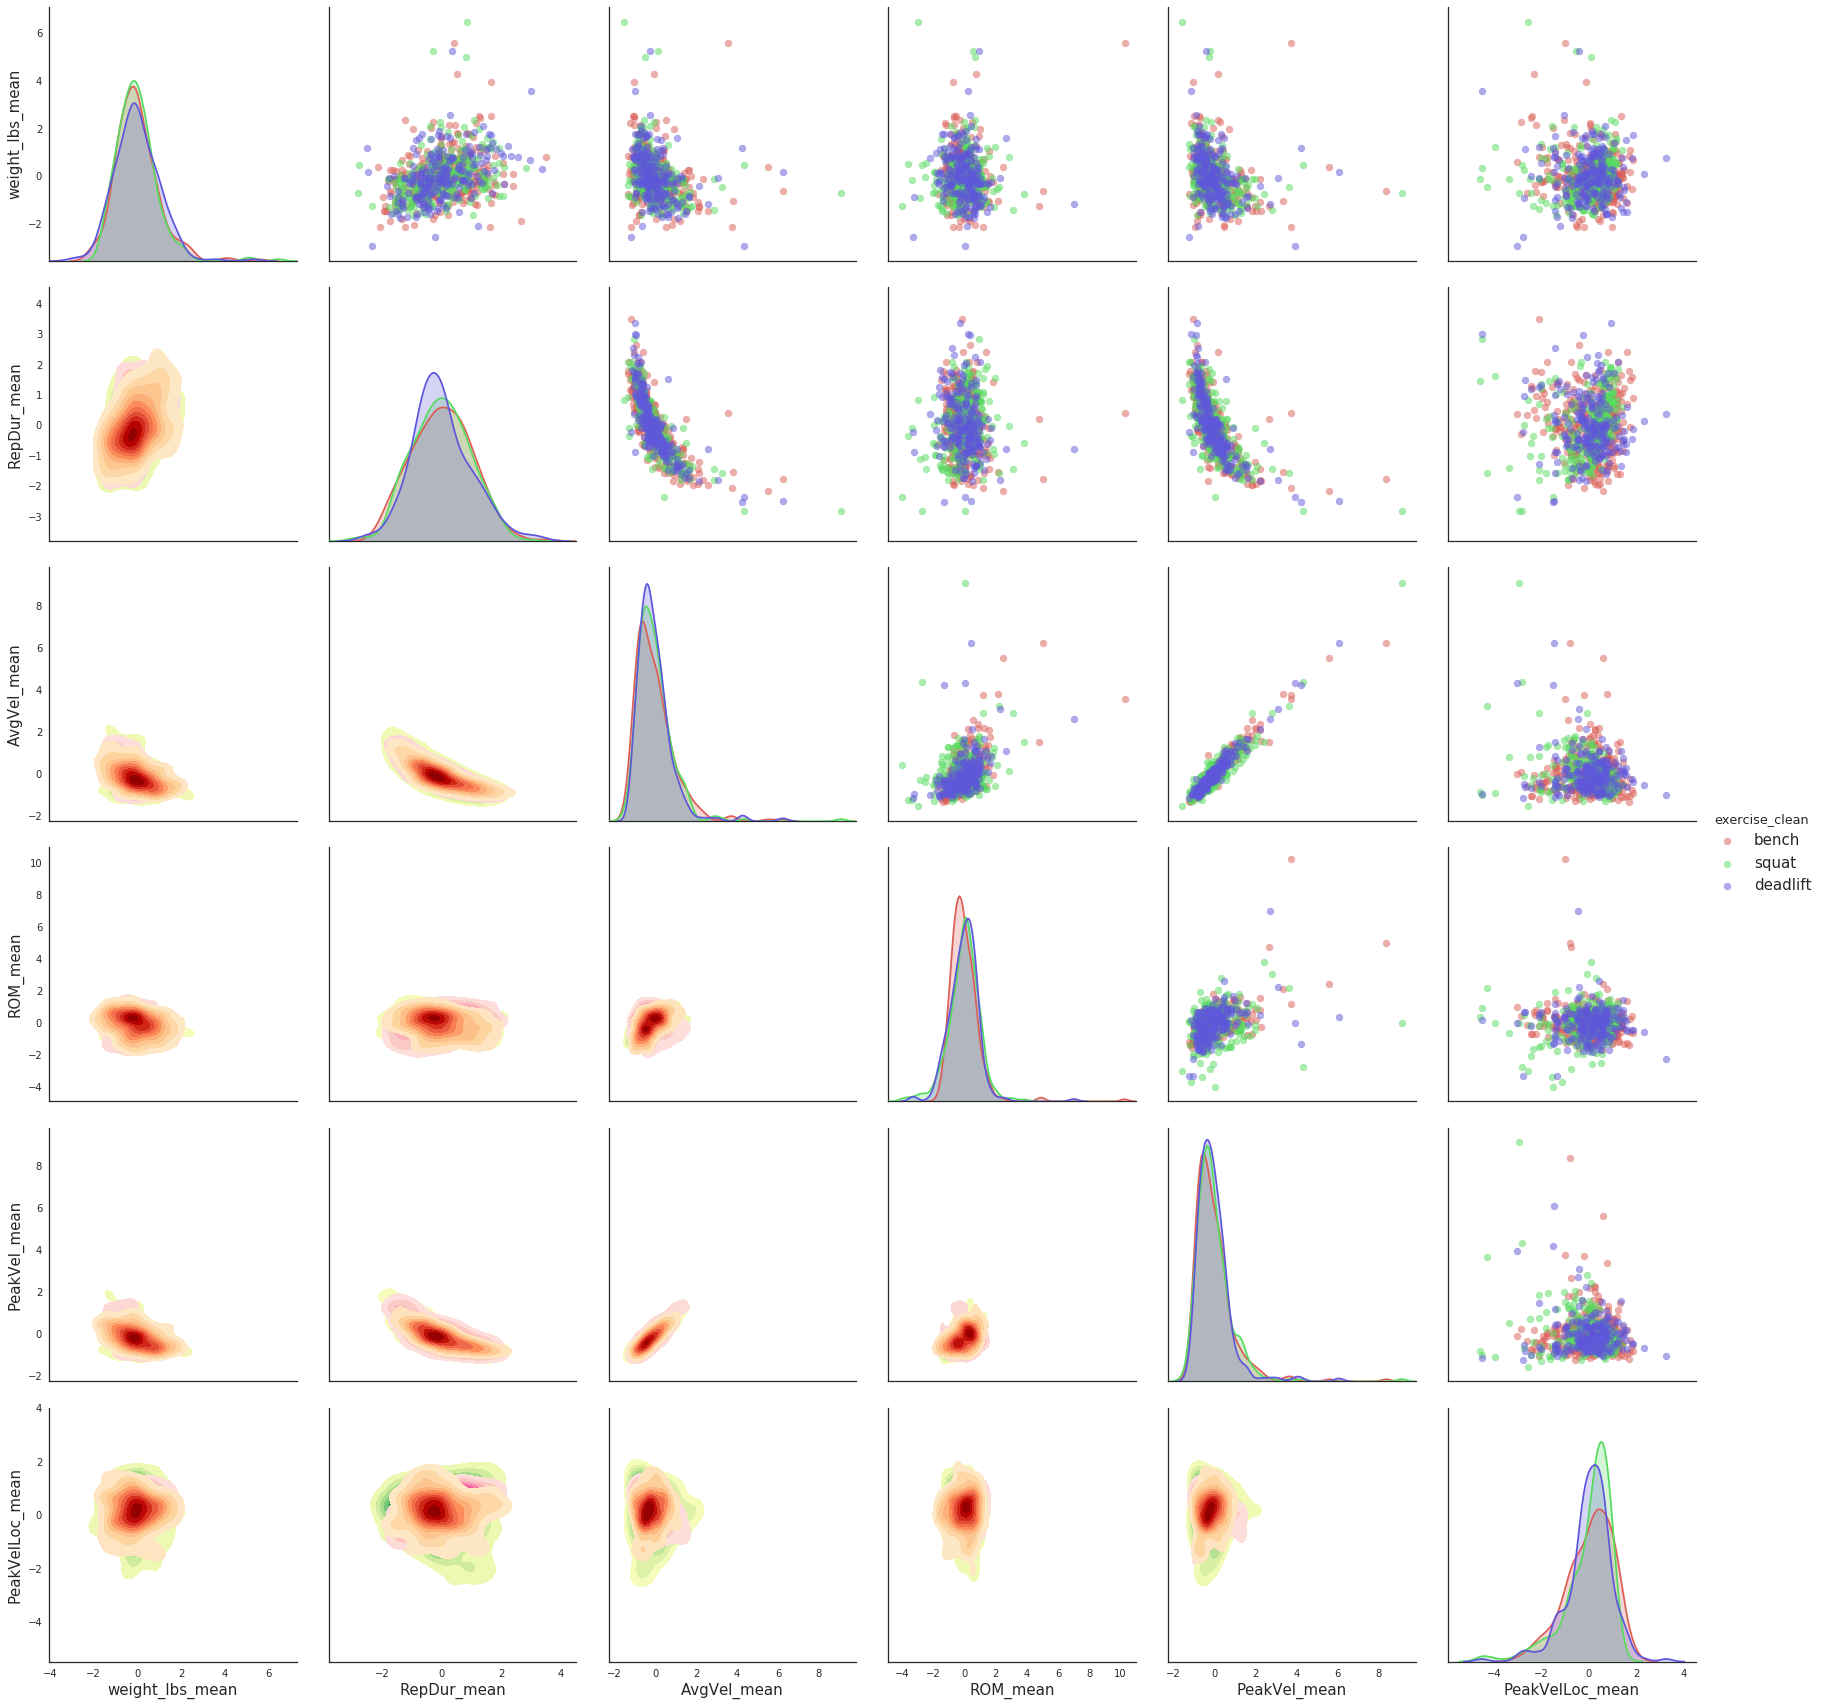

In [86]:
plot_exercise_grid(df_train, final_features)

In [49]:
def stack_pca_data(data, n_pca):
    """
    Fits PCA for each exercise and stacks them up in one dataframe

    Args:
      data: input dataframe
      n_pca: integer, number of PCs to keep

    Returns:
      dataframe with PCs    
    """

    # separate the ids
    ids = data[group_cols]

    # initialize data frame
    data_out = np.empty(shape=(0, n_pca))

    # for each exercise fit PCA
    for ex in ['bench', 'squat', 'deadlift']:
        pca_data = data[data['exercise_clean'] == ex].drop(group_cols, axis=1)
        pca_data = PCA(n_components=n_pca).fit_transform(pca_data)
        print(f"{ex} data shape: {pca_data.shape}")
        data_out = np.concatenate((data_out, pca_data), axis=0)
    print(f"Final dataset shape: {data_out.shape}")

    data_out = pd.DataFrame(data_out)
    # merge the ids back
    data_out = data_out.join(ids)

    return data_out


df_train_pca2 = stack_pca_data(df_train, 2)
df_train_pca3 = stack_pca_data(df_train, 3)

bench data shape: (290, 2)
squat data shape: (279, 2)
deadlift data shape: (222, 2)
Final dataset shape: (791, 2)
bench data shape: (290, 3)
squat data shape: (279, 3)
deadlift data shape: (222, 3)
Final dataset shape: (791, 3)


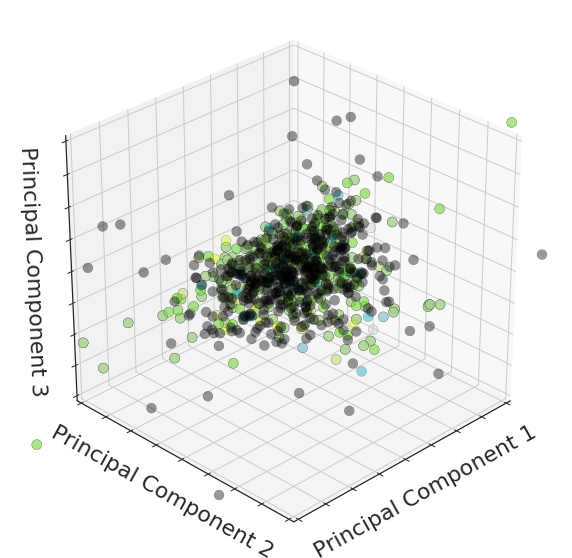

In [50]:
def make_3pca_plot(pca_data):
    """Plots PCA transformed data with 3 PCs

    Args:
        data: input dataset
    """

    exercises, labels = pca_data['exercise_clean'].factorize()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        pca_data[0],
        pca_data[1],
        pca_data[2],
        cmap=plt.cm.nipy_spectral,
        c=exercises,
        edgecolor='k',
        alpha=0.4,
        s=100)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-4, 4)
    ax.view_init(azim=45)

    plt.show()


make_3pca_plot(df_train_pca3)

### Conclusions

Not surprisingly, all three exercises appear relatively grouped in these visualizations. This is because we standardized all of the values. One thing of note here is the presence of outliers. Every parameter and every exercise appears to have several. These charts will be key later on in iterating to improve our clustering.

# 7. Hierarchical Clustering

Credit:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

And now for the exciting part. Here we form sets of clusters for each exercise and introduce the dendogram (from the link above) as an excellent means of visualizing the clustering process. Note that the parameters used in forming these clusters were the ones we selected after a substantial period of analysis and iteration.

## 7.1 Functional Setup

This section contains a series of functions that will be used and re-used by our clustering process throughout the rest of the notebook.

In [51]:
def plot_dendrogram(Z, max_d):
    """
    Plots a dendogram to visualize the provided cluster information

    Args:
        Z: hierarchical clustering information produced by linkage()
        max_d: cut-off distance for cluster selection
    """
    plt.figure(figsize=(15, 10))
    plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
    plt.xlabel('Number of members')
    plt.ylabel('distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=25,  # show only the last p merged clusters
        leaf_rotation=10.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        color_threshold=max_d)
    plt.axhline(y=max_d, c='k', ls='--')
    plt.show()


def make_clusters(data, cutoff, link='ward', dist='euclidean', verbose=False):
    """
    Forms clusters via hierarchical clustering with the given distance calculations

    Args:
        data: dataframe
        cutoff: float, cutoff value (0 to 1 scale) of where to stop clustering

    Kwargs:
        link: str, algorithm for computing distance
        dist: str, distance metric
        verbose: bool, flag to enable additional output

    Returns:
        hierarchical clustering data object,
        clustering cutoff value,
        dataset with cluster labels
    """
    IDS = data[group_cols]
    # resetting the index to ensure proper merge with clusters
    IDS.reset_index(drop=True, inplace=True)

    X = data.drop(group_cols, axis=1).values
    Z = linkage(X, link)
    max_d = cutoff * max(Z[:, 2])

    clusters = pd.DataFrame(
        fcluster(Z, max_d, criterion='distance'), columns=["Cluster"])
    clusters = pd.concat([IDS, clusters], axis=1)
    #     clusters = fcluster(Z, max_d, criterion='distance')

    if verbose:
        print(f'Maximum distance: {max(Z[:,2]):.2f}')
        print(f'Cut off distance: {max_d:.2f}')
        c, coph_dists = cophenet(Z, pdist(X))
        print('C: {0}'.format(c))
        check_frequency(clusters["Cluster"])

    return Z, max_d, clusters


def visualize_clusters_2d(X,
                          Y,
                          colors,
                          title,
                          highlight_data=None,
                          highlight_color='green',
                          highlight_size=5):
    """
    Plots a 2d scatter plot of the provided data

    Also provides the option of highlighting a data point

    Args:
        X: array, x data
        Y: array, y data
        colors: color assignment of data points
        title: title of plot

    Kwargs:
        highlight_data: [x, y], data point to highlight
        highlight_color: color of highlight point
        highlight_size: size of highlighted point
    """
    cmap = 'prism' if highlight_data is None else 'Dark2'
    sc = plt.scatter(X, Y, c=colors, cmap=cmap)
    plt.scatter(X, Y, c=colors, cmap=cmap, alpha=0.4, s=100)
    # some fancy legend plotting magic via
    # https://stackoverflow.com/questions/44595288/matplotlib-adding-legend-based-on-existing-color-series
    lp = lambda i: plt.plot([], color=sc.cmap(sc.norm(i)), mec="none",
                            label="Cluster {:g}".format(i), ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(colors)]
    # thank you
    # http://jb-blog.readthedocs.io/en/latest/posts/0012-matplotlib-legend-outdide-plot.html
    plt.legend(handles=handles, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
    if highlight_data is not None:
        plt.scatter(
            highlight_data[0],
            highlight_data[1],
            c=highlight_color,
            s=highlight_size)
    plt.title(title)
    plt.show()


def visualize_clusters_3d(X, Y, Z, colors, title):
    """
    Plots a 2d scatter plot of the provided data

    Also provides the option of highlighting a data point

    Args:
        X: array, x data
        Y: array, y data
        Z: array, z data
        colors: color assignment of data points
        title: title of plot
    """
    # http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    ax.set_facecolor('None')
    ax.scatter(
        X,
        Y,
        Z,
        c=colors,
        cmap=plt.cm.nipy_spectral,
        edgecolor='k',
        alpha=0.4,
        s=100)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.view_init(azim=45)

    plt.title(title)
    plt.show()


def visualize_clusters(data, features, clusters, title=""):
    """
    Visualizes cluster assignments in
    2d if data is two dimensional
    3d if data is three dimensional
    3d if data is more than three dimensional (will use PCA to reduce)

    Args:
        data: dataframe
        features: list, features to plot
        clusters: list, clustering information for colors

    Kwargs:
        title: title of plot
    """
    data = data.drop(group_cols, axis=1)
    print(list(data))

    if len(features) == 2:
        visualize_clusters_2d(
            data[features[0]],
            data[features[1]],
            clusters.ravel(),
            title=title)
    elif len(features) == 3:
        visualize_clusters_3d(
            data[features[0]],
            data[features[1]],
            data[features[2]],
            clusters.ravel(),
            title=title)
    elif len(features) > 3:
        print('Dimensions > 3. Running PCA with n=3.')
        pca = PCA(n_components=3)
        pca.fit(data)
        pca_train = pd.DataFrame(pca.transform(data))
        visualize_clusters_3d(
            pca_train[0],
            pca_train[1],
            pca_train[2],
            clusters.ravel(),
            title=title)

    return


def plot_outliers(data, exercise, ids, features):
    """
    Plots the outliers of provided data

    Args:
        data: dataframe
        exercise: exercise to plot
        ids: ids of outliers
        features: list of features to plot
    """

    data = data[data['exercise_clean'] == exercise]

    plt.figure(figsize=(10, 8))

    plt.scatter(
        data[features[0]],
        data[features[1]],
        c=data['Cluster'],
        cmap=plt.cm.nipy_spectral,
        edgecolor='k',
        alpha=0.4,
        s=100,
        facecolor='None')
    for user in ids:
        plt.scatter(
            data[data['userID'] == user][features[0]],
            data[data['userID'] == user][features[1]],
            c='r',
            facecolor='None')  # plot interesting points in red again
    plt.xlabel(f"{features[0]}")
    plt.ylabel(f"{features[1]}")
    plt.show()

## 7.2 Bench Press Clustering

In [55]:
# these features were selected through our iterative process
final_features_bench = [
    'weight_lbs_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean'
]

Maximum distance: 24.01
Cut off distance: 13.20
C: 0.43457621849491546

Cluster has 3 unique values
Top 10 values are:
3    117
2    116
1     57
Name: Cluster, dtype: int64

Cluster has 3 unique values
Top 10 values are:
3    117
2    116
1     57
Name: Cluster, dtype: int64


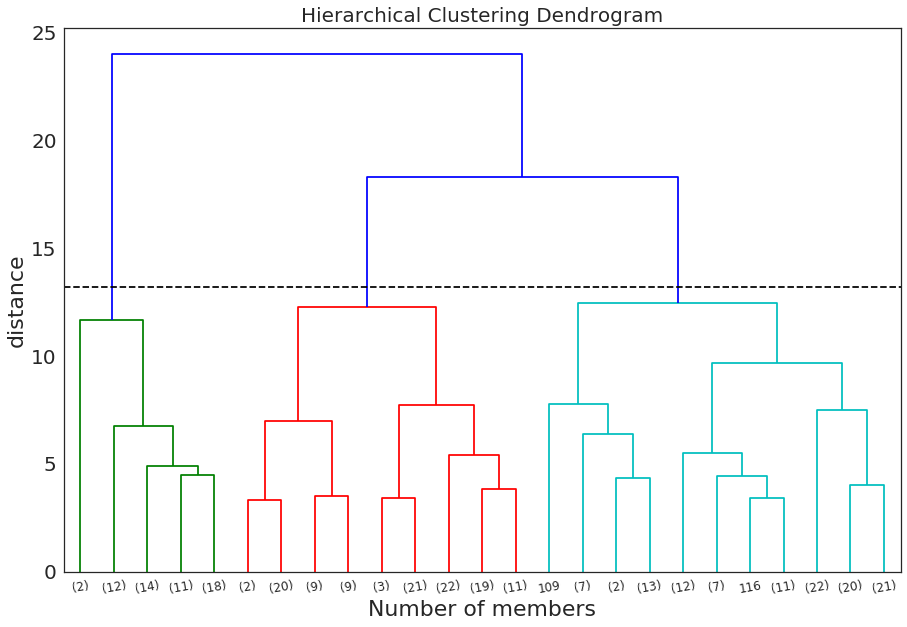

['weight_lbs_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


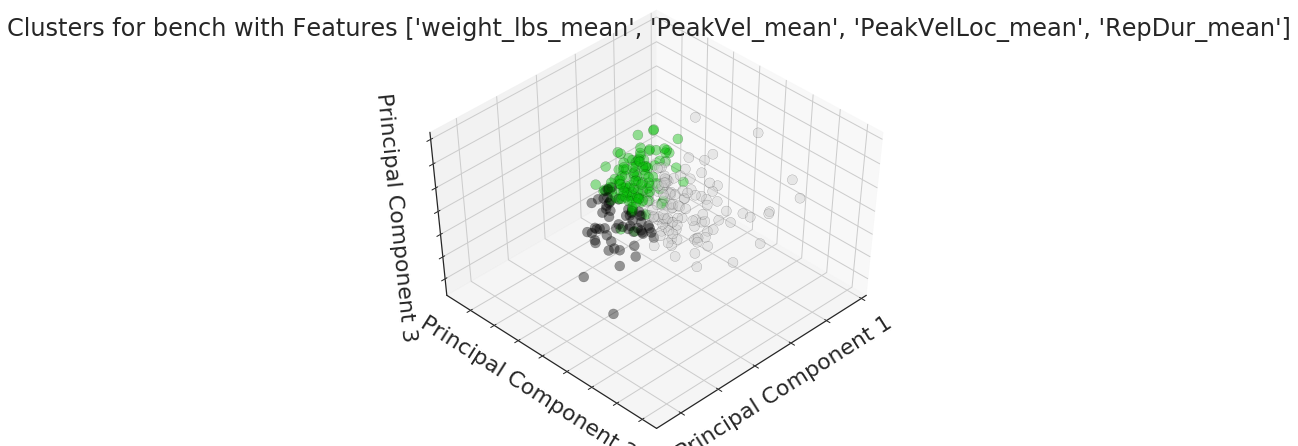

In [56]:
Z, max_d, clusters = make_clusters(
    df_bench_train[final_features_bench + group_cols], 0.55, verbose=VERBOSE)
df_bench_cluster = (df_bench_train.set_index(['userID', 'exercise_clean'])
                    .join(clusters.set_index(['userID', 'exercise_clean'])))
df_bench_cluster.reset_index(inplace=True)

# validate that clusters match make_cluster output
check_frequency(df_bench_cluster["Cluster"])
plot_dendrogram(Z, max_d)
visualize_clusters(
    df_bench_train[final_features_bench + group_cols],
    final_features_bench,
    clusters['Cluster'],
    title=f"Clusters for {'bench'} with Features {final_features_bench}")

In [57]:
# use this code to plot outliers
# ids = list(clusters[clusters["Cluster"]==2]['userID'])
# plot_outliers(df_bench_cluster, 'bench', ids, ['AvgVel_mean', 'weight_lbs_mean'])

## 7.3 Squat Clustering

In [58]:
# these features were selected through our iterative process
final_features_squat = [
    'weight_lbs_mean', 'PeakVel_mean', 'ROM_mean', 'PeakVelLoc_mean',
    'RepDur_mean'
]

Maximum distance: 25.01
Cut off distance: 13.76
C: 0.38094809502009563

Cluster has 4 unique values
Top 10 values are:
1    127
3     68
4     62
2     22
Name: Cluster, dtype: int64

Cluster has 4 unique values
Top 10 values are:
1    127
3     68
4     62
2     22
Name: Cluster, dtype: int64


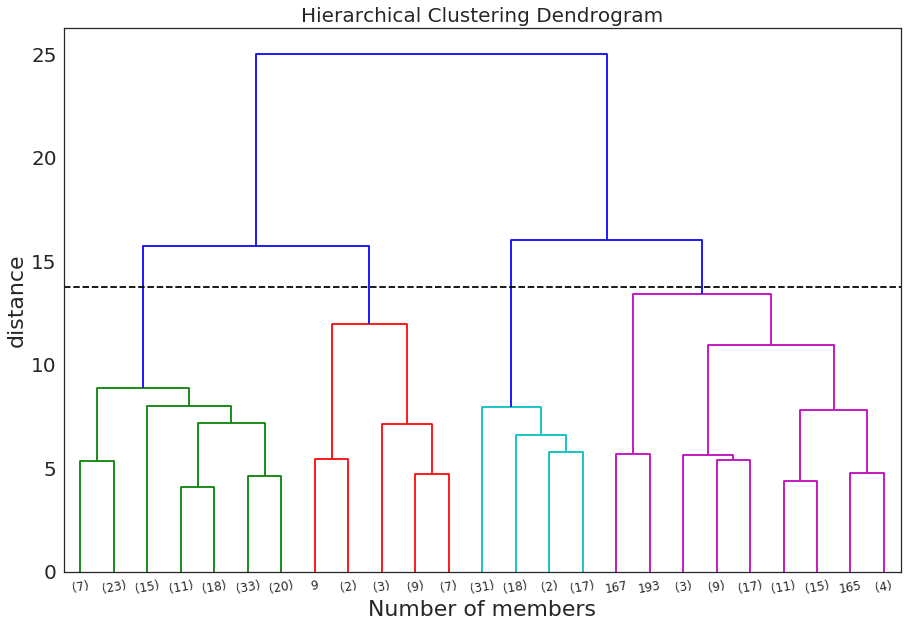

['weight_lbs_mean', 'PeakVel_mean', 'ROM_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


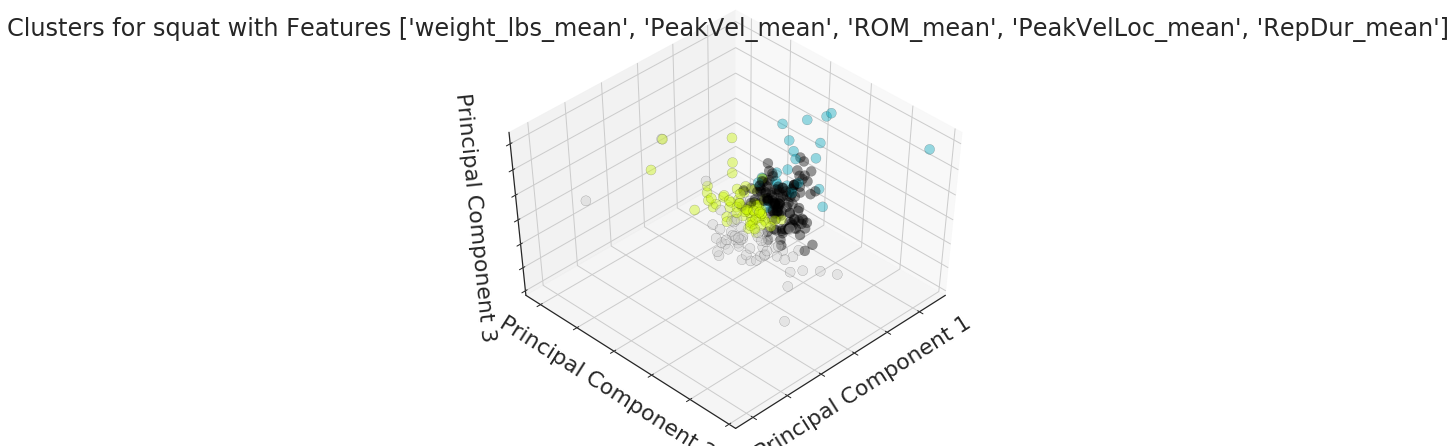

In [59]:
Z, max_d, clusters = make_clusters(
    df_squat_train[final_features_squat + group_cols], 0.55, verbose=VERBOSE)
df_squat_cluster = (df_squat_train.set_index(['userID', 'exercise_clean'])
                    .join(clusters.set_index(['userID', 'exercise_clean'])))
df_squat_cluster.reset_index(inplace=True)
# validate that clusters match make_cluster output
check_frequency(df_squat_cluster["Cluster"])
plot_dendrogram(Z, max_d)
visualize_clusters(
    df_squat_train[final_features_squat + group_cols],
    final_features_squat,
    clusters['Cluster'],
    title=f"Clusters for {'squat'} with Features {final_features_squat}")

## 7.4 Deadlift Clustering

In [60]:
# these features were selected through our iterative process
final_features_deadlift = [
    'weight_lbs_mean', 'PeakVel_mean', 'ROM_mean', 'RepDur_mean'
]

Maximum distance: 22.49
Cut off distance: 12.37
C: 0.4029081414659807

Cluster has 3 unique values
Top 10 values are:
3    93
1    80
2    49
Name: Cluster, dtype: int64

Cluster has 3 unique values
Top 10 values are:
3    93
1    80
2    49
Name: Cluster, dtype: int64


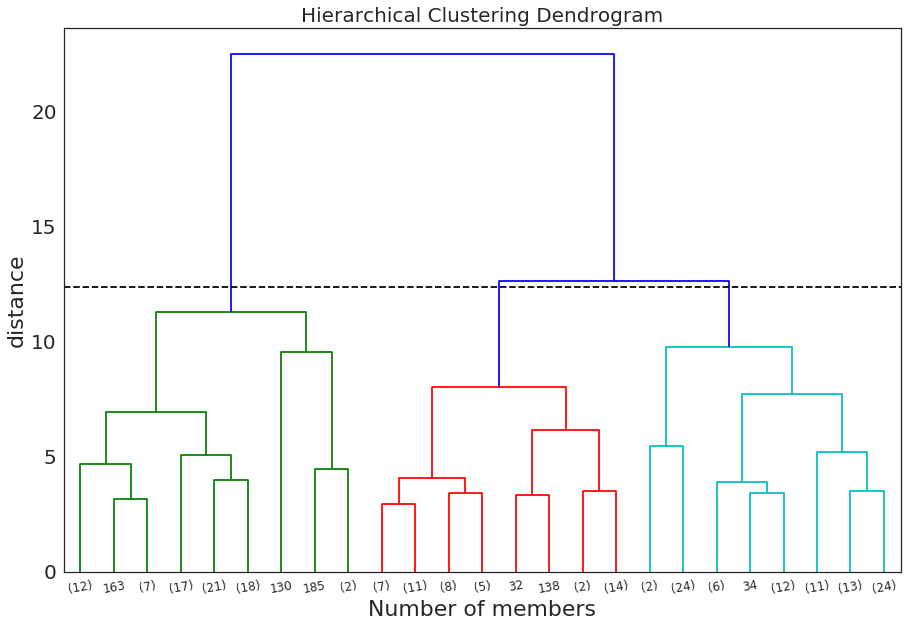

['weight_lbs_mean', 'PeakVel_mean', 'ROM_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


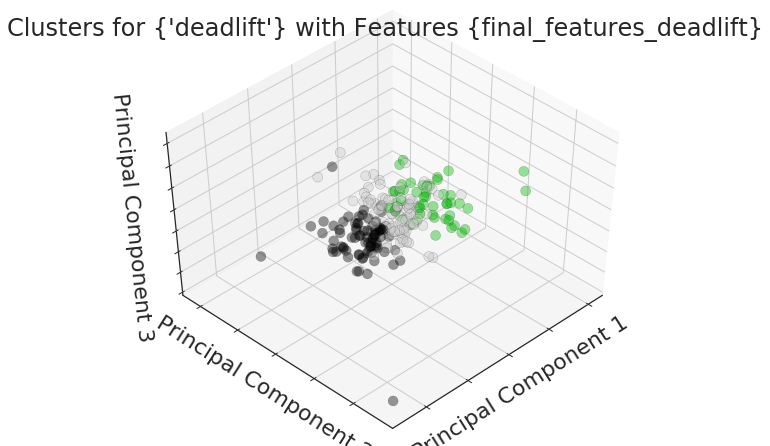

In [61]:
Z, max_d, clusters = make_clusters(
    df_deadlift_train[final_features_deadlift + group_cols],
    0.55,
    verbose=VERBOSE)
df_deadlift_cluster = (df_deadlift_train.set_index(
    ['userID', 'exercise_clean']).join(
        clusters.set_index(['userID', 'exercise_clean'])))
df_deadlift_cluster.reset_index(inplace=True)

# validate that clusters match make_cluster output
check_frequency(df_deadlift_cluster["Cluster"])
plot_dendrogram(Z, max_d)
visualize_clusters(
    df_deadlift_train[final_features_deadlift + group_cols],
    final_features_deadlift,
    clusters['Cluster'],
    title="Clusters for {'deadlift'} with Features {final_features_deadlift}")

## 7.5 Combining Clusters and Parameters

Now that we have our clusters, we explore the relationship between the parameters based on the cluster grouping to observe if some parameters had a higher impact than others.

In [62]:
# Create a dataset with all user ids
users = pd.DataFrame(df_train['userID'].unique(), columns=['userID'])

# Merge cluster membership
users = (users.merge(
    df_bench_cluster[group_cols + ['Cluster']], on='userID', how='left').merge(
        df_squat_cluster[group_cols + ['Cluster']], on='userID', how='left')
         .merge(
             df_deadlift_cluster[group_cols + ['Cluster']],
             on='userID',
             how='left'))
# Drop unnecessary columns
users.drop(
    ['exercise_clean_x', 'exercise_clean_y', 'exercise_clean'],
    axis=1,
    inplace=True)
users.columns = [
    'userID', 'Cluster_bench', 'Cluster_squat', 'Cluster_deadlift'
]
## Uncomment this to fill in clusters for users with no exercises with 0
# users.fillna(0, inplace=True)
users.head(5)

,userID,Cluster_bench,Cluster_squat,Cluster_deadlift
0,59b9b56d85ea1c6b42e4b22f,2.0,NaN,1.0
1,5a7bba5c880e87b3f32ddf40,3.0,1.0,3.0
2,5a67f20a880e87b3f32ddf21,1.0,NaN,NaN
3,58d8b1c76ca711fcd8cb7b57,2.0,NaN,3.0
4,59b96e3c85ea1c6b42e4b22c,2.0,1.0,3.0


In [63]:
# Merge clusters with training dataset
df_train_with_clusters = df_train.merge(users, on='userID', how='left')

In [71]:
df_train_with_clusters2 = df_train_with_clusters[final_features_bench+['exercise_clean', 'Cluster_bench']]
df_train_with_clusters2.columns = ['Weight', 'Peak Velocity', 'Peak Velocity Location', 'Rep Duration', 'exercise_clean', 'Cluster_bench']
df_train_with_clusters2.head()

,Weight,Peak Velocity,Peak Velocity Location,Rep Duration,exercise_clean,Cluster_bench
0,-0.032086,-0.388329,0.443024,-0.870269,bench,2.0
1,1.304882,-0.458026,-0.431920,-0.064969,bench,3.0
2,-1.275193,1.973974,-0.427462,-1.189532,bench,1.0
3,-0.689529,0.328560,1.054659,-0.791028,bench,2.0
4,0.099286,-0.487478,1.349991,0.488865,bench,2.0


/home/yulia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/yulia/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:400: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


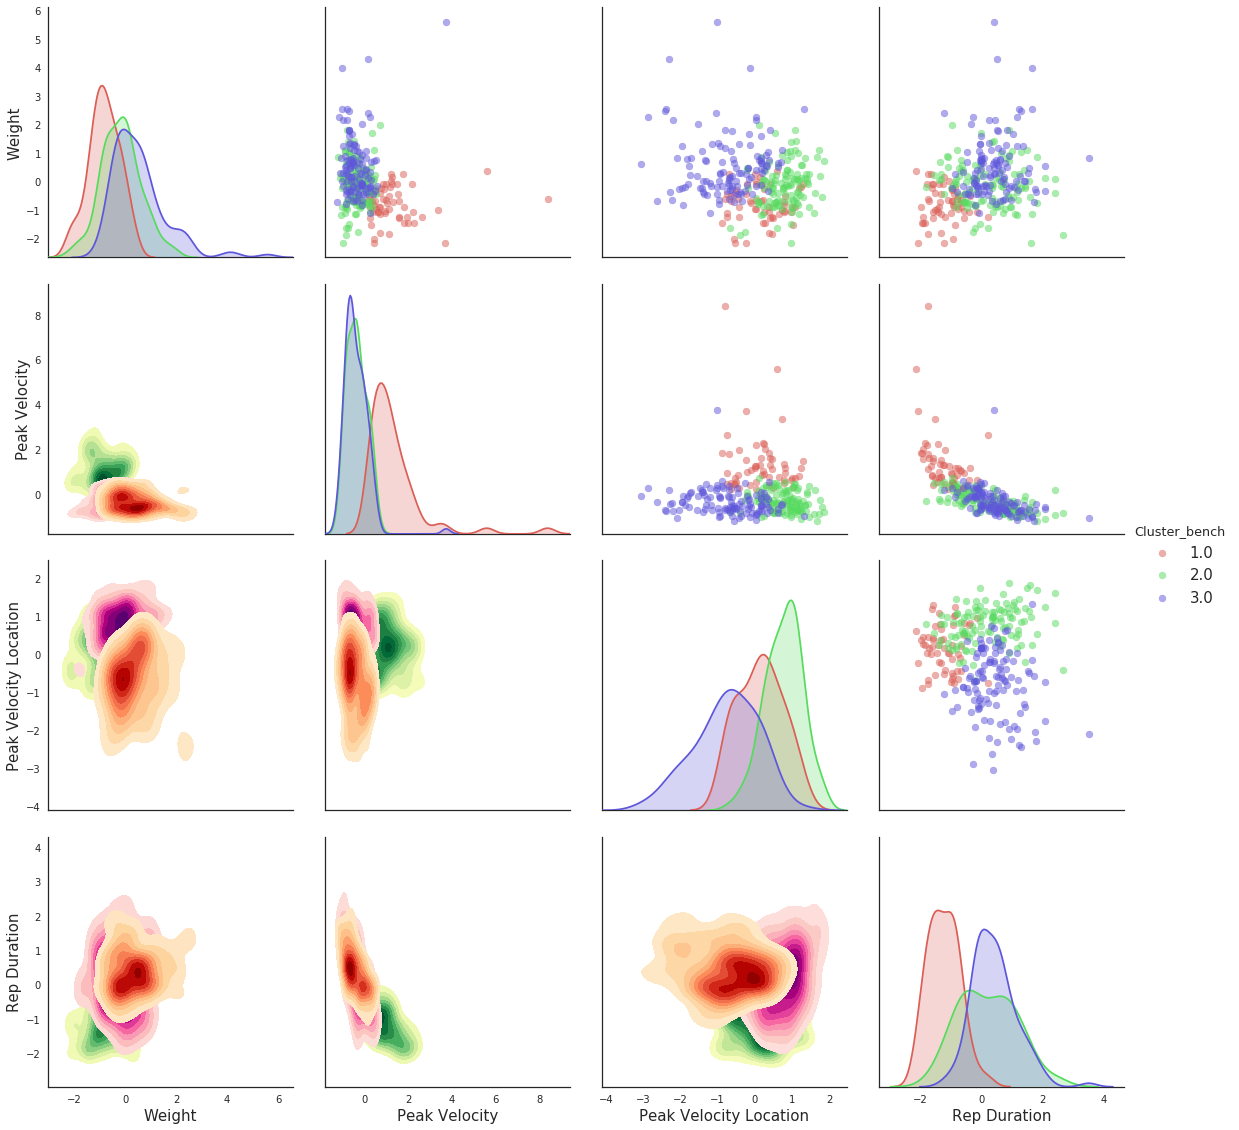

In [87]:
# Visualize features by cluster for bench
plot_exercise_grid(
    df_train_with_clusters2[df_train_with_clusters2['exercise_clean'] ==
                           'bench'], list(df_train_with_clusters2)[:-2], 'Cluster_bench')

/home/yulia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


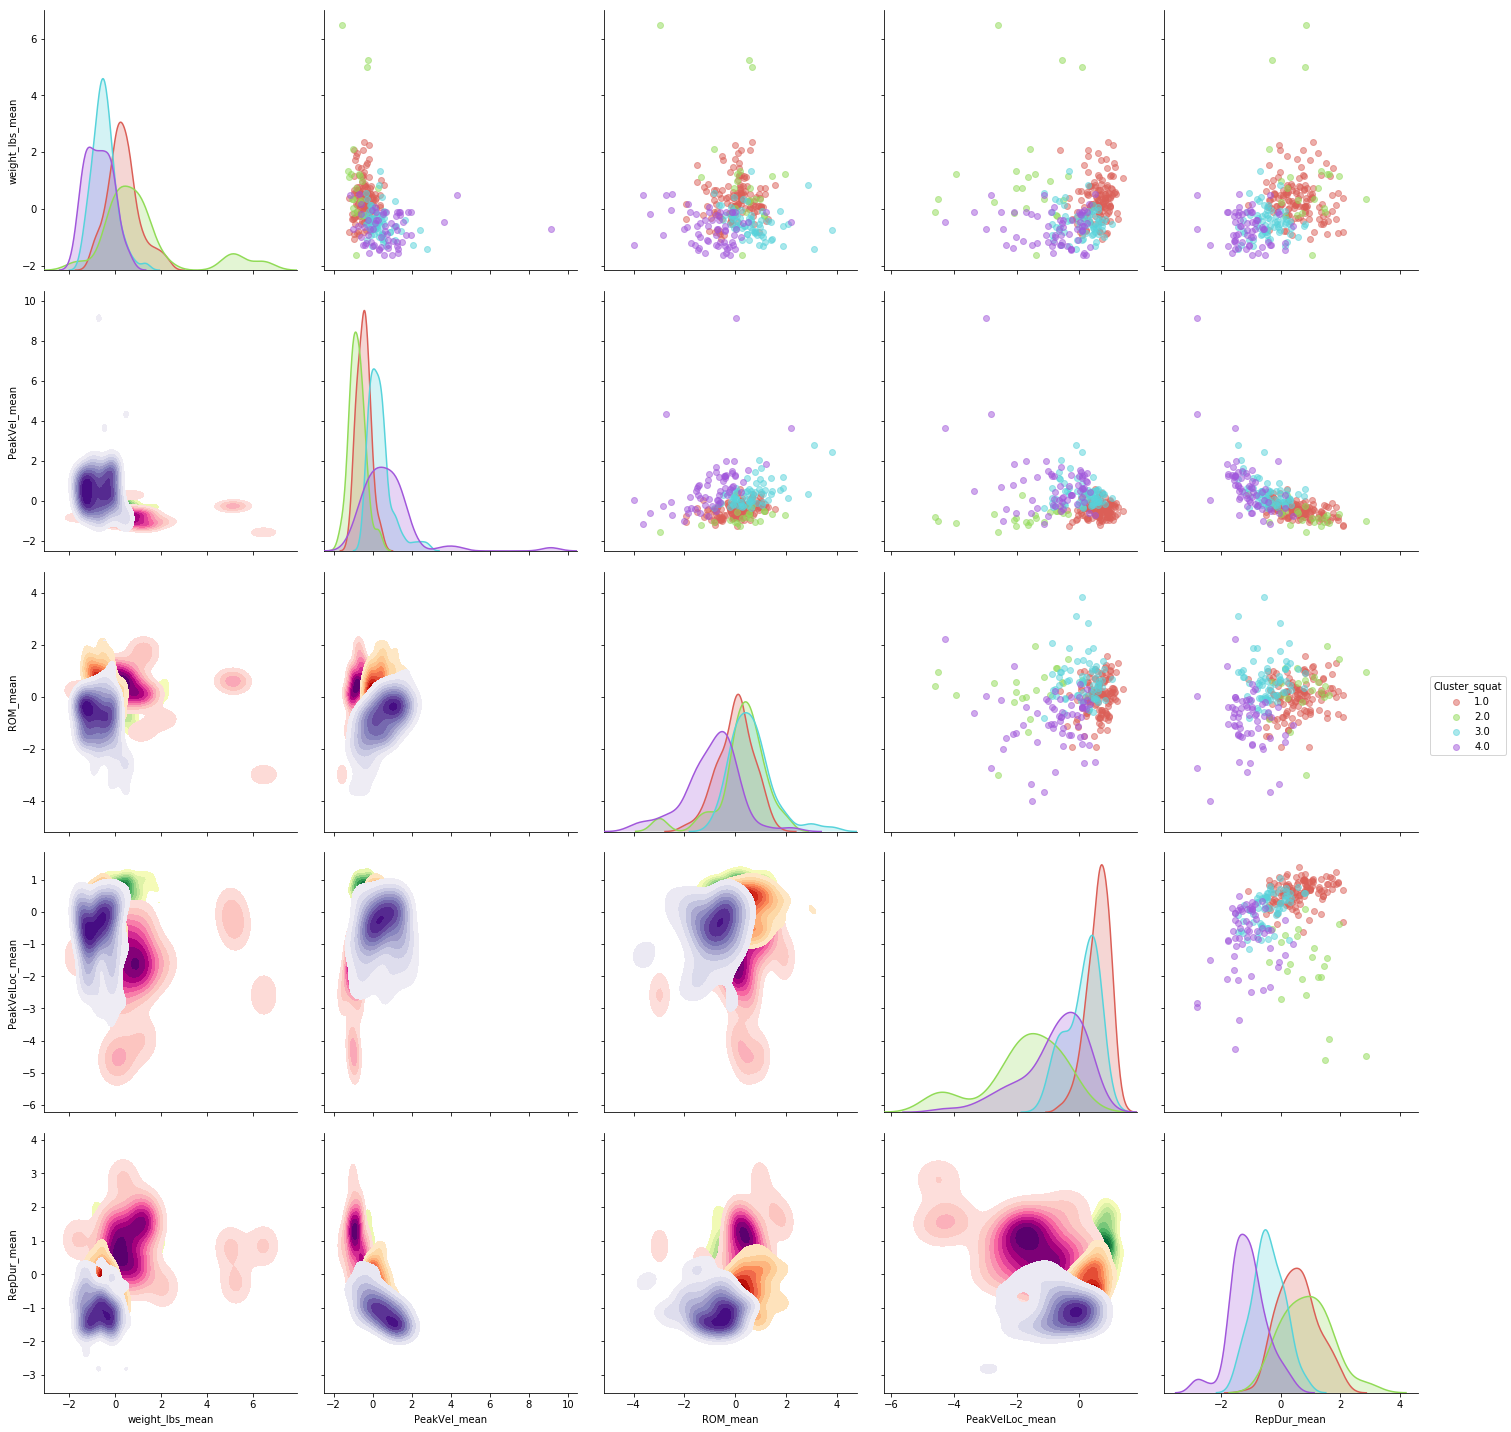

In [52]:
# Visualize features by cluster for squat
plot_exercise_grid(
    df_train_with_clusters[df_train_with_clusters['exercise_clean'] ==
                           'squat'], final_features_squat, 'Cluster_squat')

/home/yulia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


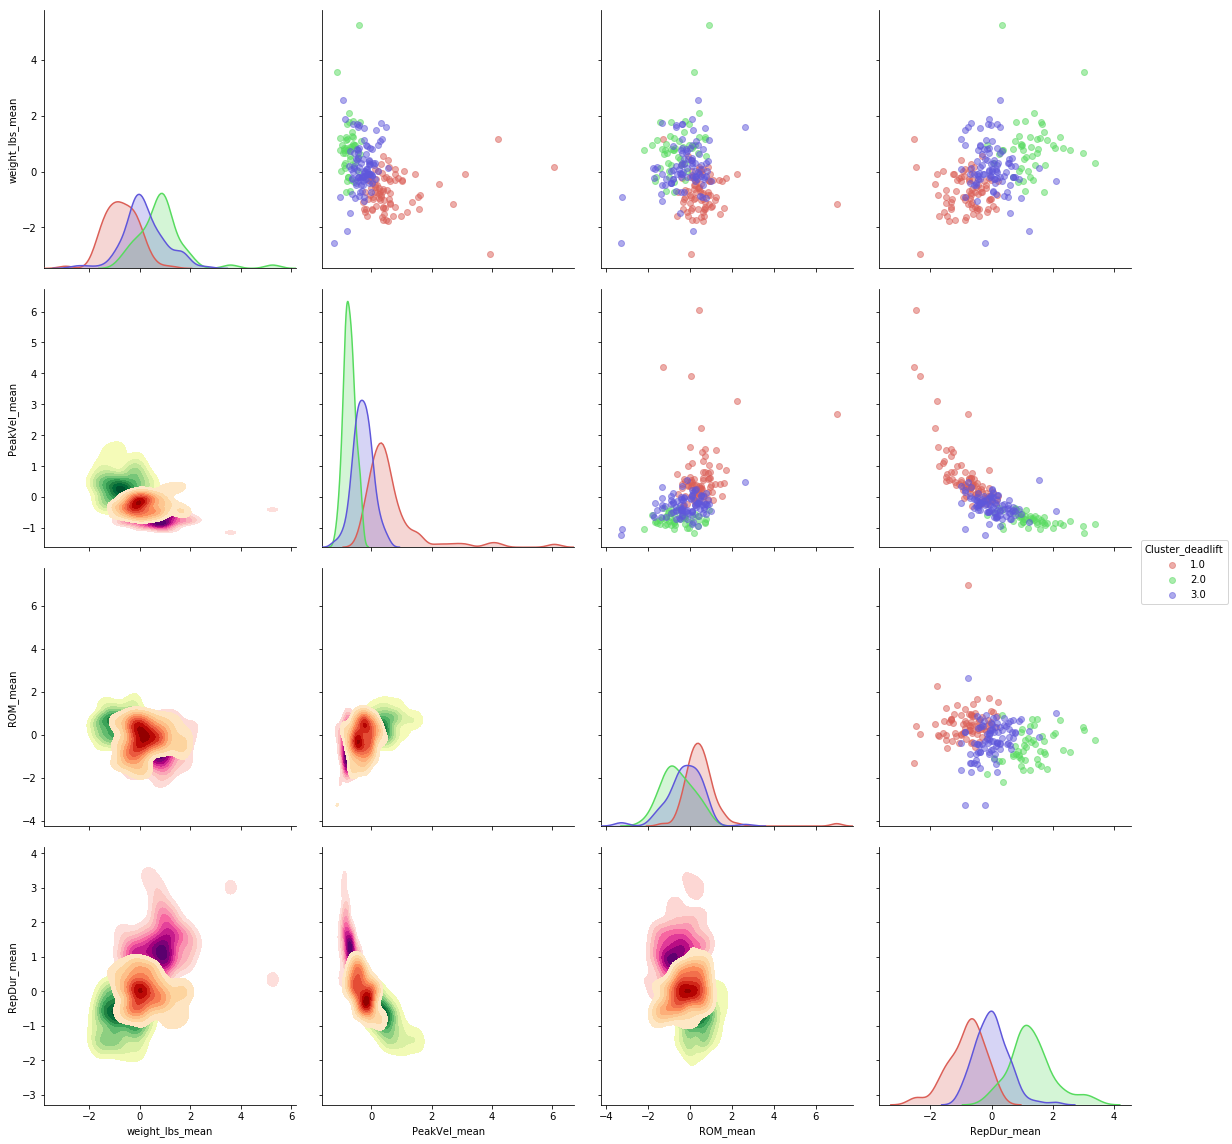

In [53]:
# Visualize features by cluster for deadlift
plot_exercise_grid(
    df_train_with_clusters[df_train_with_clusters['exercise_clean'] ==
                           'deadlift'], final_features_deadlift,
    'Cluster_deadlift')

In [54]:
# check how users overlap across exercise clusters
pd.crosstab(
    users['Cluster_bench'],
    [users['Cluster_squat'], users['Cluster_deadlift']],
    margins=True,
    dropna=False)

Cluster_squat    1.0         2.0         3.0         4.0          All
Cluster_deadlift 1.0 2.0 3.0 1.0 2.0 3.0 1.0 2.0 3.0 1.0 2.0 3.0     
Cluster_bench                                                        
1.0                0   0   3   0   0   0   3   0   1   9   0   3   57
2.0                5  12  20   0   1   3   9   2   8   1   0   4  116
3.0                5  17  16   0   1   5   5   0   3   3   0   1  117
All               10  34  42   0   2  10  18   2  12  20   0   8  395

In [55]:
# check standardized feature means by cluster membership for bench
(df_train_with_clusters[df_train_with_clusters['exercise_clean'] == 'bench']
 .groupby('Cluster_bench').mean())

,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean,Cluster_squat,Cluster_deadlift
Cluster_bench,,,,,,,,
1.0,-0.818773,-1.228189,1.414321,0.575206,1.351969,0.149323,3.305556,1.518519
2.0,-0.155981,0.208042,-0.358238,-0.298169,-0.332639,0.778115,1.952381,2.268293
3.0,0.531021,0.422099,-0.356595,-0.013743,-0.354113,-0.758078,1.646341,2.223881


In [56]:
# check standardized feature means by cluster membership for squat
(df_train_with_clusters[df_train_with_clusters['exercise_clean'] == 'squat']
 .groupby('Cluster_squat').mean())

,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean,Cluster_bench,Cluster_deadlift
Cluster_squat,,,,,,,,
1.0,0.357736,0.585136,-0.507713,0.010668,-0.453394,0.606281,2.485437,2.372093
2.0,1.193826,0.872413,-0.589354,0.263353,-0.780366,-1.768137,2.375000,2.833333
3.0,-0.478512,-0.414736,0.424815,0.630228,0.370095,0.094921,2.122449,1.812500
4.0,-0.704801,-1.108869,0.737291,-0.939367,0.740282,-0.813566,1.529412,1.571429


In [57]:
# check standardized feature means by cluster membership for deadlift
(df_train_with_clusters[df_train_with_clusters['exercise_clean'] == 'deadlift']
 .groupby('Cluster_deadlift').mean())

,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean,Cluster_bench,Cluster_squat
Cluster_deadlift,,,,,,,,
1.0,-0.736458,-0.815054,0.723027,0.522373,0.671099,0.076227,1.910714,3.000000
2.0,0.856442,1.318281,-0.789251,-0.589277,-0.721780,-0.303594,2.550000,1.157895
3.0,0.173195,0.019827,-0.273367,-0.229836,-0.279044,0.131139,2.287500,1.805556


# 8. Bringing It All Together

In this section, we introduce a tool made possible via Google Colab's environment that was critical to our iterative process of determining a good set of parameters for clustering for each exercise. Unfortunately, this tool is not possible within the traditional jupyter notebook. We created a series of "forms" that allowed us to easily manipulate the set of group columns, feature columns, aggregator functions, and clustering parameters as well as a pipeline function to perform all of the above steps all at once. The results was an interface that made rapid iteration possible.

In [0]:
#@title Select Groupby Columns
userID = True  #@param {type:"boolean"}
exercise_clean = True  #@param {type:"boolean"}
workoutID = False  #@param {type:"boolean"}

# Form - Groups
group_cols = list()
if userID:
    group_cols.append('userID')
if exercise_clean:
    group_cols.append('exercise_clean')
if workoutID:
    group_cols.append('workoutID')

In [0]:
#@title Select Exercise
exercise = "squat" #@param ["squat", "bench", "deadlift"]

In [0]:
#@title Select Feature Columns
rpe_num = False  #@param {type:"boolean"}
weight_lbs = True  #@param {type:"boolean"}
RepCount = False  #@param {type:"boolean"}
ROM = True  #@param {type:"boolean"}
AvgVel = False  #@param {type:"boolean"}
PeakVel = True  #@param {type:"boolean"}
PeakVelLoc = True  #@param {type:"boolean"}
RepDur = True  #@param {type:"boolean"}
PeakAccel = False  #@param {type:"boolean"}

# Form - Features
feature_cols = list()
if rpe_num:
    feature_cols.append('rpe_num')
if weight_lbs:
    feature_cols.append('weight_lbs')
if RepCount:
    feature_cols.append('RepCount')
if ROM:
    feature_cols.append('ROM')
if AvgVel:
    feature_cols.append('AvgVel')
if PeakVel:
    feature_cols.append('PeakVel')
if PeakVelLoc:
    feature_cols.append('PeakVelLoc')
if RepDur:
    feature_cols.append('RepDur')
if PeakAccel:
    feature_cols.append('PeakAccel')

In [0]:
#@title Select Feature Aggregators
np_mean = True  #@param {type:"boolean"}
np_min = False  #@param {type:"boolean"}
np_max = False  #@param {type:"boolean"}
np_std = False  #@param {type:"boolean"}

# Form - Aggs
aggregator_funcs = list()
if np_mean:
  aggregator_funcs.append(np.mean)
if np_min:
  aggregator_funcs.append(np.min)
if np_max:
  aggregator_funcs.append(np.max)
if np_std:
  aggregator_funcs.append(np.std)

In [0]:
#@title Hierarchical Clustering Setup

cutoff = 0.55  #@param {type:"slider", min:0, max:1, step:0.01}
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_algo = 'ward'  #@param ["ward", "single", "complete", "average", "weighted", "centroid"]
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
distance_algo = 'euclidean'  #@param ["ward", "minkowski", "cityblock", "euclidean", "seuclidean", "sqeuclidean", "cosine", "correlation", "hamming"]

In [0]:
def lifter_segmentation(data, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, dendo=False, verbose=False):
    """
    Pipeline function containing all of the key hierarchical clustering steps

    Args:
        data: dataframe
        exercise: str, exercise to produce clusters for
        group_cols: list, columns to group by
        feature_cols: list, columns to be used as features
        aggregator_funcs: list, numpy functions to aggregate rows when grouping
        cutoff: float, cutoff value for selecting clusters
        linkage_algo: str, linkage algo for clustering
        distance_algo: str, metric for computing distance when clustering

    Kwargs:
        dendo: bool, flag to enable plotting of dendogram (disable for speedup)
        verbose: bool, flag to enable additional output

    Returns:
        train data dataframe
        test data dataframe
        cluster assignments
        sklearn fitted scaler object
    """
    df_exercise = select_exercise(data, exercise, verbose=verbose)
    if verbose:
        print()
    df_grouped, final_features = group_and_aggregate_data(df_exercise, group_cols, feature_cols, aggregator_funcs, verbose=verbose)
    if verbose:
        print()
    df_imputed = impute_data(df_grouped, verbose=verbose)
    if verbose:
        print()
    df_clean, scaler = standardize_data(df_imputed, verbose=verbose)
    if verbose:
        print()
    df_train, df_test = train_test_split(df_clean, test_size=0.1, shuffle=True, random_state=5)
    if verbose:
        print()
    Z, max_d, clusters = make_clusters(df_train, cutoff, link=linkage_algo, dist=distance_algo, verbose=verbose)
    if verbose:
        print()
    if dendo:
        plot_dendrogram(Z, max_d)
    if verbose:
        print()
    visualize_clusters(df_train, final_features, clusters['Cluster'], title="Clusters for {0} with Features {1}".format(exercise, final_features))

    return df_train, df_test, clusters, scaler


Selected Exercise "squat": shape_before=(292910, 45), shape_after=(77680, 45)

Aggregated Data: shape=(311, 5)
Features=['weight_lbs_mean', 'ROM_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Grouped and Aggregated Data: shape=(311, 7)


Feature means before impute:
 weight_lbs_mean        277.98
ROM_mean               610.40
PeakVel_mean             1.06
PeakVelLoc_mean         79.14
RepDur_mean        1179591.54
dtype: float64

Number of missing values: 21

Feature means after impute:
 weight_lbs_mean        277.54
ROM_mean               610.40
PeakVel_mean             1.06
PeakVelLoc_mean         79.18
RepDur_mean        1179478.17
dtype: float64

Number of missing after impute:
 weight_lbs_mean    0
ROM_mean           0
PeakVel_mean       0
PeakVelLoc_mean    0
RepDur_mean        0
dtype: int64


Means of standardized features:
 weight_lbs_mean    0.0
ROM_mean           0.0
PeakVel_mean      -0.0
PeakVelLoc_mean    0.0
RepDur_mean        0.0
dtype: float64

Std dev of sta

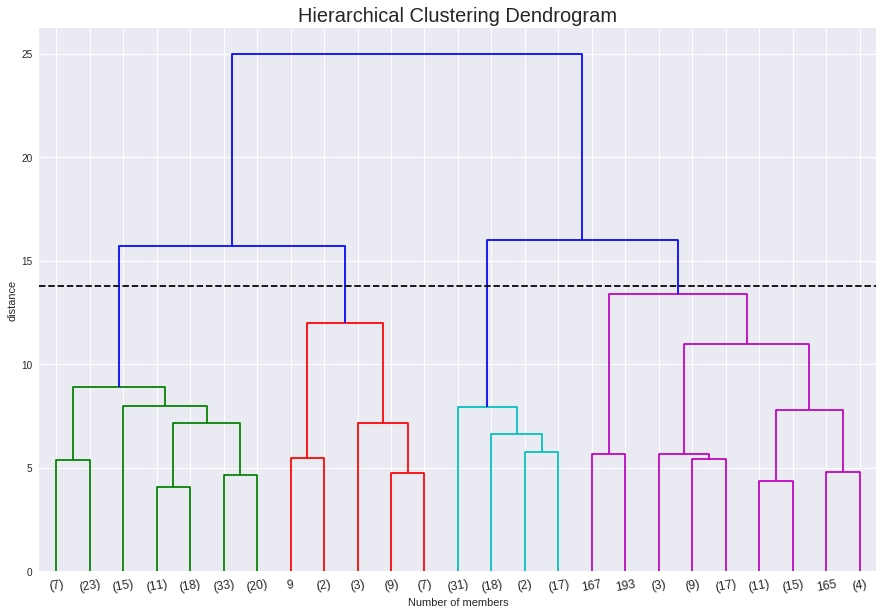


['weight_lbs_mean', 'ROM_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


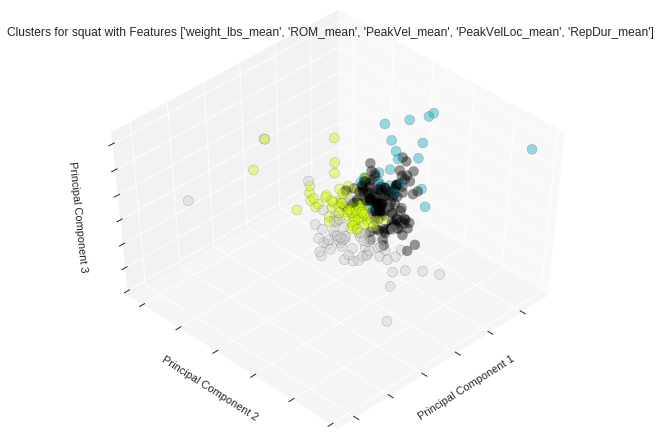

In [89]:
_, _, _, _ = lifter_segmentation(df, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, dendo=True, verbose=True)

# 9. Validation

We now have clusters but are they accurate? To assess this, we use the number of clusters formed by hierarchical clustering to fit a K Nearest Neighbors classifier to predict the clusters and see if the clusters overlap. 

In [0]:
def validate_cluster(data_train, data_test, final_features, clusters):
    """
    - Fits K-means using number of clusters derived via Hierarchical clustering
    - Checks if clusters overlap
    - Predicts cluster membership on the test data and prints out the frequency
    of predicted clusters

    Args:
        data_train: training dataframe
        data_test: testing dataframe
        final_features: list, features to use for clustering
        clusters: array, cluster membership
    """

    # get number of clusters derived in hierarchical clustering
    n_clus = clusters['Cluster'].value_counts().shape[0]

    KnnClsf = KNeighborsClassifier(n_clus)
    KnnClsf = KnnClsf.fit(data_train[final_features], clusters['Cluster'])

    # get train clusters and put them into series
    KnnClsf_train = pd.Series(
        KnnClsf.predict(data_train[final_features]), name="KMeans_Cluster")
    # predict cluster membership on test data
    KnnClsf_test = pd.Series(
        KnnClsf.predict(data_test[final_features]), name="KMeans_Cluster")

    print("Hierarchical Clusters vs. K-means:\n")
    print(
        pd.crosstab(
            clusters['Cluster'], KnnClsf_train, margins=True, dropna=False))

    print("\nCluster frequency in the test data:")
    check_frequency(KnnClsf_test)

In [100]:
# validate the clusters produced for bench press in section 7 above
# NOTE: only use if bench press is selected
validate_cluster(df_bench_train, df_bench_test, final_features_bench, df_bench_cluster)

Hierarchical Clusters vs. K-means:

KMeans_Cluster   1    2    3  All
Cluster                          
1               56    1    0   57
2                0  115    1  116
3                0    0  117  117
All             56  116  118  290

Cluster frequency in the test data:

KMeans_Cluster has 3 unique values
Top 10 values are:
3    16
1     9
2     8
Name: KMeans_Cluster, dtype: int64


In [101]:
# validate the clusters produced for deadlift in section 7 above
# NOTE: only use if deadlift is selected
validate_cluster(df_deadlift_train, df_deadlift_test, final_features_deadlift, df_deadlift_cluster)

Hierarchical Clusters vs. K-means:

KMeans_Cluster   1   2   3  All
Cluster                        
1               79   0   1   80
2                0  49   0   49
3                0   1  92   93
All             79  50  93  222

Cluster frequency in the test data:

KMeans_Cluster has 3 unique values
Top 10 values are:
3    12
1     8
2     5
Name: KMeans_Cluster, dtype: int64


In [103]:
# validate the clusters produced for squat in section 7 above
# NOTE: only use if squat is selected
validate_cluster(df_squat_train, df_squat_test, final_features_squat, df_squat_cluster)

Hierarchical Clusters vs. K-means:

KMeans_Cluster    1   2   3   4  All
Cluster                             
1               127   0   0   0  127
2                 2  20   0   0   22
3                 4   1  63   0   68
4                 1   0   4  57   62
All             134  21  67  57  279

Cluster frequency in the test data:

KMeans_Cluster has 4 unique values
Top 10 values are:
1    20
3     7
4     4
2     1
Name: KMeans_Cluster, dtype: int64


#### Are we close?

Yes! Deadlift and Bench Press only have a handful of cluster assignments that differ. Squat has a few more but still the count is very low.

In [59]:
def reverse_standardization(scaler, data):
    """
    Using a fitted Scaler, we inverse the scaling effect on the data

    Args:
        scaler: fitted sklearn scaler
        data: dataframe

    Returns:
        inverse transformed dataframe
    """
    new_data = scaler.inverse_transform(data)
    df_new_data = pd.DataFrame(
        new_data, columns=data.columns, index=data.index)
    return df_new_data

In [85]:
bench_ids = df_bench_cluster[['userID','exercise_clean','Cluster']]
bench_ids.head(5)

,userID,exercise_clean,Cluster
0,59b9b56d85ea1c6b42e4b22f,bench,2
1,5a7bba5c880e87b3f32ddf40,bench,3
2,5a67f20a880e87b3f32ddf21,bench,1
3,58d8b1c76ca711fcd8cb7b57,bench,2
4,59b96e3c85ea1c6b42e4b22c,bench,2


In [90]:
df_bench_train_rev = reverse_standardization(scaler_bench, df_bench_cluster.drop(['userID','exercise_clean','Cluster'], axis=1))
df_bench_train_rev.shape

(290, 6)

In [91]:
df_bench_train_rev = pd.concat([bench_ids, df_bench_train_rev], axis=1, join_axes=[bench_ids.index])
df_bench_train_rev.shape

(290, 9)

In [92]:
df_bench_train_rev.head(5)

,userID,exercise_clean,Cluster,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean
0,59b9b56d85ea1c6b42e4b22f,bench,2,199.215686,6.849494e+05,0.411686,268.379310,0.529036,69.853448
1,5a7bba5c880e87b3f32ddf40,bench,3,296.112230,9.074897e+05,0.381205,329.027027,0.504045,56.054054
2,5a67f20a880e87b3f32ddf21,bench,1,109.121795,5.967229e+05,0.944645,426.448718,1.376095,56.124359
3,58d8b1c76ca711fcd8cb7b57,bench,2,151.567625,7.068473e+05,0.443591,309.062500,0.786093,79.500000
4,59b96e3c85ea1c6b42e4b22c,bench,2,208.736842,1.060539e+06,0.338608,347.368421,0.493484,84.157895


In [105]:
 df_bench_grouped.loc[df_bench_grouped['userID'] == '59b9b56d85ea1c6b42e4b22f']

,userID,exercise_clean,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean
156,59b9b56d85ea1c6b42e4b22f,bench,199.215686,684949.405172,0.411686,268.37931,0.529036,69.853448


In [106]:
df_bench_grouped.loc[df_bench_grouped['userID'] == '59b96e3c85ea1c6b42e4b22c']

,userID,exercise_clean,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean,PeakVel_mean,PeakVelLoc_mean
155,59b96e3c85ea1c6b42e4b22c,bench,208.736842,1.060539e+06,0.338608,347.368421,0.493484,84.157895


In [120]:
means_df = round(df_bench_train_rev.groupby(['Cluster']).mean(),2)
means_df.columns = (['Weight (lbs)', 'Rep Duration (ms)', 'Average Velocity', 'ROM',
       'Peak Velocity', 'Peak Velocity Location'])
means_df

,Weight (lbs),Rep Duration (ms),Average Velocity,ROM,Peak Velocity,Peak Velocity Location
Cluster,,,,,,
1,142.20,586040.32,0.78,396.63,1.15,65.22
2,190.24,982934.73,0.38,315.34,0.55,75.14
3,240.03,1042088.44,0.38,341.81,0.54,50.91


In [117]:
means_df

,Weight,Rep_Duration,AvgVel,ROM_mean,PeakVel_mean,PeakVelLoc_mean
Cluster,,,,,,
1,142.20,586040.32,0.78,396.63,1.15,65.22
2,190.24,982934.73,0.38,315.34,0.55,75.14
3,240.03,1042088.44,0.38,341.81,0.54,50.91


# 10. Example User

Finally, now that we have our clusters and have validated them, we can demonstrate how our users will benefit. Here, we fit a simple K Nearest Neighbors classifier to our now labeled data. We then select a random user from the dataset and use the trained KNN model to identify which cluster they belong to. From there, we present the user with useful information about other lifters in their cluster that they can compare themselves to.

In [0]:
def join_data_and_clusters(data, clusters):
    """
    Joins a set of clusters to a dataframe assuming they are the same length

    Args:
        data: dataframe
        clusters: pd.Series, clusters

    Returns:
        dataframe with new 'cluster' column
    """
    df_joined = data.copy(deep=True)
    df_joined['cluster'] = clusters
    return df_joined

['weight_lbs_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


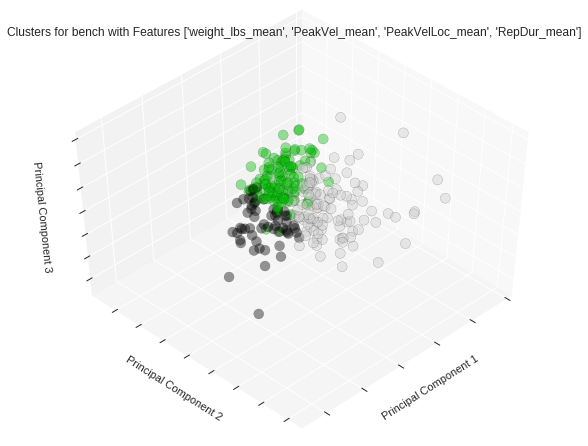

In [122]:
# start with the same settings as "Bench Clustering" from earlier
ex_exercise = 'bench'
ex_group_cols = ['userID', 'exercise_clean']
ex_feature_cols = ['weight_lbs', 'PeakVel', 'PeakVelLoc', 'RepDur']
ex_agg = [np.mean]
ex_train, ex_test, ex_clusters, ex_scaler = lifter_segmentation(
    df,
    exercise=ex_exercise,
    group_cols=ex_group_cols,
    feature_cols=ex_feature_cols,
    aggregator_funcs=ex_agg,
    cutoff=0.55,
    linkage_algo='ward',
    distance_algo='euclidean',
    dendo=False,
    verbose=False)

In [123]:
# have a quick look at the data to make sure it all came out okay
print('clusters shape = {0}'.format(ex_clusters.shape))
print('df_train shape = {0}'.format(ex_train.shape))
print('df_test  shape = {0}'.format(ex_test.shape))

clusters shape = (290, 3)
df_train shape = (290, 6)
df_test  shape = (33, 6)


In [124]:
# we need to unscale the data so that the numbers we report back are intuitive and mean something to the user
# the original scale was done on a DF with just data columns, so we remove them here and scale
cols_to_drop = ['userID','exercise_clean']
train_cols_to_add_back = ex_train[cols_to_drop]
ex_train_dropped = ex_train.drop(cols_to_drop, axis=1)
ex_train_unscaled = reverse_standardization(ex_scaler, ex_train_dropped)
ex_train_unscaled.describe()

,weight_lbs_mean,PeakVel_mean,PeakVelLoc_mean,RepDur_mean
count,290.000000,290.000000,290.000000,2.900000e+02
mean,200.882750,0.664627,63.414258,9.287899e+05
std,73.321348,0.360770,15.340618,2.777966e+05
min,45.000000,0.228535,14.750000,3.297118e+05
25%,151.940883,0.436919,53.196384,7.240135e+05
50%,192.753753,0.582659,65.716063,9.202059e+05
75%,236.687705,0.773441,75.303156,1.117900e+06
max,606.270500,3.668828,92.333333,1.897218e+06


In [0]:
# fit the KNN
KnnClsf = KNeighborsClassifier(len(np.unique(ex_clusters['Cluster'])))
KnnClsf = KnnClsf.fit(ex_train_dropped, ex_clusters['Cluster'])

In [0]:
def draw_pct_number_line(line_min, line_max, value, title=None):
    """
    Draws a number line with a highlighted value

    Args:
        line_min: float, minimum line value
        line_max: float, maximum line value
        value: float, value to highlight on the line

    Kwargs:
        title: title of number line
    """
    # thank you
    # https://stackoverflow.com/questions/23186804/graph-point-on-straight-line-number-line-in-python

    # set up the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    # draw lines
    line_max = round(line_max, 2)
    line_min = round(line_min, 2)
    line_range = line_max - line_min
    value_pt = value - line_min
    value_pctile = value_pt / line_range
    value_x = value_pctile * 9
    xmin = 1
    xmax = 9
    y = 5
    height = 1

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px = 4
    # + 1 because line starts at x=1
    plt.plot(value_x + 1, y, 'ro', ms=15, mfc='r')

    # add an arrow
    #plt.annotate('Price five days ago', (px,y), xytext = (px - 1, y + 1),
    #              arrowprops=dict(facecolor='black', shrink=0.1),
    #              horizontalalignment='right')

    # add numbers
    plt.text(xmin - 0.1, y, line_min, horizontalalignment='right')
    plt.text(xmin - 0.1, y - .5, "(0%)", horizontalalignment='right')
    plt.text(xmax + 0.1, y, line_max, horizontalalignment='left')
    plt.text(xmax + 0.1, y - .5, "(100%)", horizontalalignment='left')
    plt.text(
        value_x + 1, y + .7, round(value, 2), horizontalalignment='center')
    plt.text(
        value_x + 1,
        y - 1,
        "({0}%)".format(int(value_pctile * 100)),
        horizontalalignment='center')
    if title:
        plt.title(title)

    plt.axis('off')
    plt.show()

The Example User:

    weight_lbs_mean PeakVel_mean PeakVelLoc_mean  RepDur_mean
100         237.782     0.324866         69.8533  1.21011e+06

The Example User Scaled:

     weight_lbs_mean  PeakVel_mean  PeakVelLoc_mean  RepDur_mean
100         0.500046     -0.957724         0.443013       1.0301

Predicted Cluster =

3

Useful info about Cluster 3:



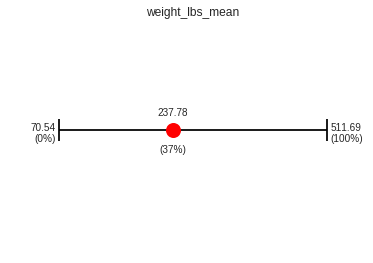

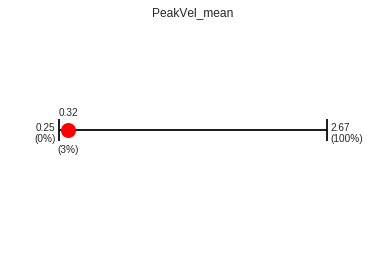

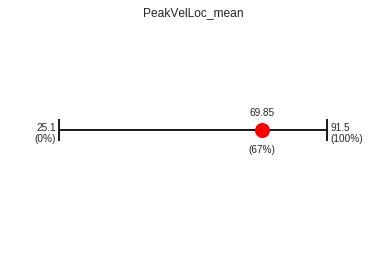

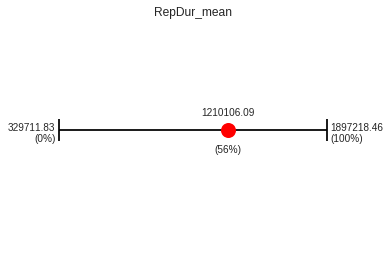

In [131]:
# Select a random user
df_users, _ = group_and_aggregate_data(
    df, ex_group_cols, ex_feature_cols, ex_agg, verbose=False)
n = 100
ex_user = pd.DataFrame(df_users.iloc[n]).T
ex_user = ex_user.drop(cols_to_drop, axis=1)

print('The Example User:\n')
print(ex_user)

# scale the user so that the KNN prediction is accurate
print('\nThe Example User Scaled:\n')
ex_user_scaled = pd.DataFrame(
    ex_scaler.transform(ex_user), columns=ex_user.columns, index=ex_user.index)
print(ex_user_scaled)

ex_user_cluster = KnnClsf.predict(ex_user_scaled)[0]

print('\nPredicted Cluster =\n\n{0}'.format(ex_user_cluster))

print('\nUseful info about Cluster {0}:\n'.format(ex_user_cluster))

ex_df_clustered = join_data_and_clusters(ex_train_unscaled,
                                         ex_clusters['Cluster'])
ex_df_clustered = ex_df_clustered[ex_df_clustered['cluster'] ==
                                  ex_user_cluster]

# make the number lines!
for col in list(ex_df_clustered.drop('cluster', axis=1).columns):
    col_series = ex_df_clustered[col]
    # because we use the grouped means of each col, there's a chance that the exact user is
    # outside of the bounds of the viz; we correct for that here
    user_value = ex_user.iloc[0][col]
    if user_value > col_series.max():
        user_value = col_series.max()
    elif user_value < col_series.min():
        user_value = col_series.min()
    draw_pct_number_line(
        col_series.min(),
        col_series.max(),
        user_value,
        title="{0}".format(col))

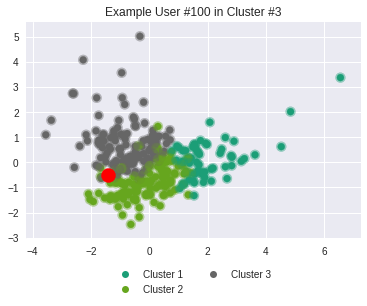

In [128]:
# plot user on 2d scatter plot - this does not work as well as the PCA'd x and y
# axes do not translate well to actionable terms for the user
pca = PCA(n_components=2)
pca.fit(ex_train_dropped)
pca_train = pd.DataFrame(pca.transform(ex_train_dropped))
pca_user = pca.transform(ex_user_scaled)
visualize_clusters_2d(pca_train[0], pca_train[1], ex_clusters['Cluster'].ravel(), title='Example User #{0} in Cluster #{1}'.format(n, ex_user_cluster), highlight_data=pca_user[0], highlight_color='#FF0000', highlight_size=200)

#### How does this help the user?

The above number lines show the user where he/she compares to other lifters in her cluster for each actionable parameter. For example, this user might observe that although he/she is relatively average in terms of weight lifted and rep duration, he/she is at the bottom of his/her cluster in terms of peak velocity. This information can be used to calibrate their training more effectively.



# Summary

In this notebook, we successfully cleaned, grouped, and clustered the provided data from OpenBarbell based on each of the three core exercises: bench press, squat, and deadlift. We validated the clusters using KNN and visualized them using Seaborn and matplotlib. We also introduced a tool inside of Google Colab's environment to enable rapid iteration of model improvement. Finally, we demonstrated a possible use-case of a real user applying this clustering algorithm to acquire feedback on his/her lifting performance and training plan.